# EDA

## Librerias

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import shapiro, normaltest, kstest,f_oneway, kruskal, chi2_contingency, levene,mannwhitneyu
from statsmodels.stats.outliers_influence import variance_inflation_factor

## Cargado de datos

In [3]:
df=pd.read_csv("data/data.csv",na_values=[' '])

In [4]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## Funciones

In [5]:
def Summary(data, sheet):
    print(f"Hoja: {sheet}")

    # Crear la tabla de resumen
    resumen = {
        "Cantidad de filas": data.shape[0],
        "Cantidad de columnas": data.shape[1],
        "Datos faltantes": data.isnull().sum().sum(),
        "Filas duplicadas": data.duplicated().sum()
    }

    # Convertir el resumen en un DataFrame
    ResumenHoja = pd.DataFrame(resumen, index=["Resumen"])
    print("\nResumen:")
    display(ResumenHoja)

    print("\nEncabezado:")
    display(data.head())

In [6]:
def graficar_distribuciones(df, columnas, bins=30):
    sns.set(style="whitegrid", palette="muted")
    n = len(columnas)
    
    fig, axes = plt.subplots(nrows=n, ncols=2, figsize=(12, 4*n))
    
    for i, col in enumerate(columnas):
        # Histograma con KDE
        sns.histplot(data=df, x=col, kde=True, bins=bins, ax=axes[i,0], color="skyblue")
        axes[i,0].set_title(f"Histograma de {col}", fontsize=12)
        axes[i,0].set_xlabel("")
        axes[i,0].set_ylabel("Frecuencia")
        
        # Boxplot
        sns.boxplot(data=df, x=col, ax=axes[i,1], color="lightcoral")
        axes[i,1].set_title(f"Boxplot de {col}", fontsize=12)
        axes[i,1].set_xlabel("")
    
    plt.suptitle("Distribuciones de variables numéricas", fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

In [7]:
def graficar_categoricas(df,cat):
    for col  in cat:
        df[col].value_counts()
        sns.countplot(data=df, x=col, order=df[col].value_counts().index)
        plt.title(f'Distribución de {col}')
        plt.xticks(rotation=45)
        plt.show()

In [8]:
def prueba_normalidad(df, alpha=0.05):
    resultados = []

    # Detectar variables numéricas
    numericas = df.select_dtypes(include=[np.number]).columns

    for col in numericas:
        serie = df[col].dropna()

        if len(serie) < 8:  # muy pocas muestras → no confiable
            resultados.append({
                "variable": col,
                "n_muestras": len(serie),
                "shapiro_p": np.nan,
                "dagostino_p": np.nan,
                "ks_p": np.nan,
                "es_normal (alpha=0.05)": "Muestra insuficiente"
            })
            continue

        # Shapiro-Wilk (solo si n <= 5000, más grande no recomendado)
        stat_shapiro, p_shapiro = shapiro(serie) if len(serie) <= 5000 else (np.nan, np.nan)

        # D’Agostino y Pearson
        stat_dagostino, p_dagostino = normaltest(serie)

        # Kolmogorov-Smirnov contra normal estándar
        stat_ks, p_ks = kstest(
            (serie - serie.mean()) / serie.std(ddof=0), 'norm'
        )

        # Veredicto final
        es_normal = (
            (np.isnan(p_shapiro) or p_shapiro > alpha) and
            (p_dagostino > alpha) and
            (p_ks > alpha)
        )

        resultados.append({
            "variable": col,
            "n_muestras": len(serie),
            "shapiro_p": p_shapiro,
            "dagostino_p": p_dagostino,
            "ks_p": p_ks,
            "es_normal (alpha=0.05)": es_normal
        })

    return pd.DataFrame(resultados).sort_values(by="es_normal (alpha=0.05)", ascending=False)

In [9]:
def analisis_bivariado_numerico(df, top=5, mostrar_graficos=True):
    # Seleccionar solo las columnas numéricas
    num_df = df.select_dtypes(include=[np.number])
    cols = num_df.columns

    if len(cols) < 2:
        raise ValueError("Se necesitan al menos dos variables numéricas para el análisis bivariado.")
    
    resultados = []

    # Calcular correlaciones entre todas las parejas posibles
    for var1, var2 in combinations(cols, 2):
        valid_data = num_df[[var1, var2]].dropna()  
        pearson = valid_data[var1].corr(valid_data[var2], method='pearson')
        spearman = valid_data[var1].corr(valid_data[var2], method='spearman')
        covarianza = np.cov(valid_data[var1], valid_data[var2])[0, 1]

        resultados.append({
        'Variable 1': var1,
        'Variable 2': var2,
        'Correlación Pearson': pearson,
        'Correlación Spearman': spearman,
        'Covarianza': covarianza
        })
    
    corr_df = pd.DataFrame(resultados).sort_values(by='Correlación Spearman', ascending=False)
    
    print("===  Correlaciones más altas ===")
    display(corr_df.head(top))
    print("\n=== Correlaciones más bajas ===")
    display(corr_df.tail(top))

    # Gráficos opcionales para las correlaciones más altas y más bajas
    if mostrar_graficos:
        pares_altas = corr_df.head(top)
        pares_bajas = corr_df.tail(top)
        pares_interes = pd.concat([pares_altas, pares_bajas])

        for _, row in pares_interes.iterrows():
            var1, var2 = row['Variable 1'], row['Variable 2']
            plt.figure(figsize=(6,5))
            sns.regplot(x=var1, y=var2, data=num_df, scatter_kws={'alpha':0.6}, line_kws={'color':'red'})
            plt.title(f"{var1} vs {var2}\nCorrelación Spearman: {row['Correlación Spearman']:.3f}")
            plt.show()
    
    return corr_df

In [10]:
def analisis_bivariado_categorico(df, top=5, mostrar_graficos=True, grafico='heatmap'):
    # Filtrar solo variables categóricas
    cat_df = df.select_dtypes(include=['object', 'category'])
    cols = cat_df.columns.tolist()

    if len(cols) < 2:
        raise ValueError("Se necesitan al menos dos variables categóricas para el análisis bivariado.")

    resultados = []

    # Iterar sobre todas las combinaciones posibles de variables categóricas
    for var1, var2 in combinations(cols, 2):
        # Crear tabla de contingencia
        tabla = pd.crosstab(df[var1], df[var2])

        # Evitar tablas muy pequeñas
        if tabla.shape[0] < 2 or tabla.shape[1] < 2:
            continue

        # Prueba Chi-cuadrado
        chi2, p, dof, expected = chi2_contingency(tabla)

        # Calcular V de Cramer
        n = tabla.sum().sum()
        phi2 = chi2 / n
        r, k = tabla.shape
        phi2corr = max(0, phi2 - ((k - 1)*(r - 1)) / (n - 1))
        rcorr = r - ((r - 1)**2) / (n - 1)
        kcorr = k - ((k - 1)**2) / (n - 1)
        cramer_v = np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1))) if min(kcorr, rcorr) > 1 else 0

        resultados.append({
            'Variable 1': var1,
            'Variable 2': var2,
            'Chi-cuadrado': chi2,
            'Grados de libertad': dof,
            'Valor p': p,
            'V de Cramer': cramer_v
        })

    # Convertir resultados a DataFrame
    resumen_df = pd.DataFrame(resultados).sort_values(by='Valor p', ascending=True).reset_index(drop=True)

    if resumen_df.empty:
        print("No se encontraron combinaciones categóricas válidas.")
        return resumen_df

    # Mostrar top relaciones significativas
    print("=== Relaciones categóricas más significativas (menor valor p) ===")
    display(resumen_df.head(top))

    print("\n=== Relaciones menos significativas ===")
    display(resumen_df.tail(top))

    # Graficar top relaciones más significativas
    if mostrar_graficos:
        print("\nGráficos de las relaciones más significativas:")
        top_pairs = resumen_df.head(top)

        for _, row in top_pairs.iterrows():
            var1, var2 = row['Variable 1'], row['Variable 2']
            print(f"\n{var1} vs {var2} (p = {row['Valor p']:.4f}, V de Cramer = {row['V de Cramer']:.3f})")

            # Normalizar por filas para mostrar proporciones
            tabla_rel = pd.crosstab(df[var1], df[var2], normalize='index')

            plt.figure(figsize=(7, 5))
            if grafico == 'heatmap':
                sns.heatmap(tabla_rel, annot=True, cmap='YlGnBu', fmt=".2f")
                plt.title(f"{var1} vs {var2}\n(p = {row['Valor p']:.4f}, V = {row['V de Cramer']:.3f})")
                plt.xlabel(var2)
                plt.ylabel(var1)
                plt.tight_layout()
                plt.show()

    return resumen_df

In [11]:
def analisis_bivariado_cat_num(df, categoricas=None, numericas=None, mostrar_graficos=True):
    if categoricas is None:
        categoricas = df.select_dtypes(include=['object', 'category']).columns.tolist()
    if numericas is None:
        numericas = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

    resultados = []

    for cat in categoricas:
        for num in numericas:
            grupos = [df[num][df[cat] == nivel].dropna() for nivel in df[cat].dropna().unique()]
            grupos = [g for g in grupos if len(g) > 1]
            if len(grupos) < 2:
                continue

            # ==== NORMALIDAD (Kolmogorov-Smirnov) ====
            normalidades = []
            for g in grupos:
                # Estandarizamos los datos para comparar contra N(0,1)
                g_std = (g - np.mean(g)) / np.std(g, ddof=1)
                _, p_norm = kstest(g_std, 'norm')
                normalidades.append(p_norm > 0.05)

            # ==== HOMOCEDASTICIDAD (Levene) ====
            stat_lev, p_levene = levene(*grupos)
            homocedasticas = p_levene > 0.05

            # ==== ELECCIÓN DE PRUEBA ====
            if all(normalidades) and homocedasticas:
                prueba = "ANOVA"
                stat, p_valor = f_oneway(*grupos)
            else:
                prueba = "Kruskal-Wallis"
                stat, p_valor = kruskal(*grupos)

            resultados.append({
                'Categórica': cat,
                'Numérica': num,
                'Prueba': prueba,
                'Normalidad_OK': all(normalidades),
                'Homocedasticidad_OK': homocedasticas,
                'p-Levene': p_levene,
                'Estadístico': stat,
                'p-valor': p_valor
            })

            # ==== GRÁFICO ====
            if mostrar_graficos:
                plt.figure(figsize=(8, 6))
                sns.boxplot(x=cat, y=num, hue=cat, data=df, palette="Set2", legend=False)
                plt.title(f'{num} por {cat}\n({prueba}, p={p_valor:.4f})')
                plt.xticks(rotation=45,ha='right')
                plt.tight_layout()
                plt.show()

    return pd.DataFrame(resultados)

In [12]:
def cramers_v(x, y):
        confusion = pd.crosstab(x, y)
        chi2 = chi2_contingency(confusion)[0]
        n = confusion.sum().sum()
        phi2 = chi2 / n
        r, k = confusion.shape
        phi2corr = max(0, phi2 - ((k - 1)*(r - 1)) / (n - 1))
        rcorr = r - ((r - 1)**2) / (n - 1)
        kcorr = k - ((k - 1)**2) / (n - 1)
        return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))

In [13]:
def analizar_colinealidad_y_correlaciones(df, umbral_vif=10, mostrar_graficos=True):
    resultados = {}

    # Variables numéricas y categóricas
    num_vars = df.select_dtypes(include=['int64', 'float64']).columns
    cat_vars = df.select_dtypes(include=['object', 'category']).columns
    cat_vars = cat_vars.drop('customerID', errors='ignore')
    # ===============================
    # CORRELACIONES NUMÉRICAS
    # ===============================
    if len(num_vars) > 1:
        corr_pearson = df[num_vars].corr(method='pearson')
        corr_spearman = df[num_vars].corr(method='spearman')
        resultados['corr_pearson'] = corr_pearson
        resultados['corr_spearman'] = corr_spearman

        if mostrar_graficos:
            plt.figure(figsize=(10, 6))
            sns.heatmap(corr_pearson, annot=True, fmt=".2f", cmap='coolwarm', center=0)
            plt.title('Matriz de correlación (Pearson)', fontsize=13)
            plt.xticks(rotation=45, ha='right')
            plt.yticks(rotation=0)
            plt.tight_layout()
            plt.show()

            plt.figure(figsize=(10, 6))
            sns.heatmap(corr_spearman, annot=True, fmt=".2f", cmap='vlag', center=0)
            plt.title('Matriz de correlación (Spearman)', fontsize=13)
            plt.xticks(rotation=45, ha='right')
            plt.yticks(rotation=0)
            plt.tight_layout()
            plt.show()

    # ===============================
    # COLINEALIDAD (VIF)
    # ===============================
    if len(num_vars) > 1:
        X = df[num_vars].dropna()
        vif_data = pd.DataFrame({
            "Variable": X.columns,
            "VIF": [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
        })
        vif_data["Colinealidad"] = np.where(vif_data["VIF"] > umbral_vif, "Alta", "Aceptable")
        resultados['vif'] = vif_data

    # ===============================
    # CORRELACIONES CATEGÓRICAS (Cramér’s V)
    # ===============================
    if len(cat_vars) > 1:
        matriz_cramer = pd.DataFrame(
            np.ones((len(cat_vars), len(cat_vars))),
            index=cat_vars, columns=cat_vars
        )
        for var1, var2 in combinations(cat_vars, 2):
            val = cramers_v(df[var1], df[var2])
            matriz_cramer.loc[var1, var2] = val
            matriz_cramer.loc[var2, var1] = val
        resultados['cramers_v'] = matriz_cramer

        if mostrar_graficos:
            plt.figure(figsize=(10, 8))
            sns.heatmap(matriz_cramer, annot=True, fmt=".2f", cmap='YlGnBu', center=0)
            plt.title("Correlación entre variables categóricas (Cramérs V)", fontsize=13)
            plt.xticks(rotation=45, ha='right')
            plt.yticks(rotation=0)
            plt.tight_layout()
            plt.show()
    return resultados['vif']

## Analisis Exploratorio de datos

In [14]:
Summary(df,'df')

Hoja: df

Resumen:


,Cantidad de filas,Cantidad de columnas,Datos faltantes,Filas duplicadas
Resumen,7043,21,11,0



Encabezado:


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


Podemos observar que algunos de los tipos de variables se deben cambiar antes de realizar cualquier analisis posterior

In [16]:
df['SeniorCitizen']=df['SeniorCitizen'].astype("object")
df['TotalCharges']=df['TotalCharges'].astype("float64")

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   object 
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


### Analisis univariado

analizamos las variables numericas

In [18]:
df.describe()

,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7032.000000
mean,32.371149,64.761692,2283.300441
std,24.559481,30.090047,2266.771362
min,0.000000,18.250000,18.800000
25%,9.000000,35.500000,401.450000
50%,29.000000,70.350000,1397.475000
75%,55.000000,89.850000,3794.737500
max,72.000000,118.750000,8684.800000


In [19]:
numericas=['tenure','MonthlyCharges','TotalCharges']

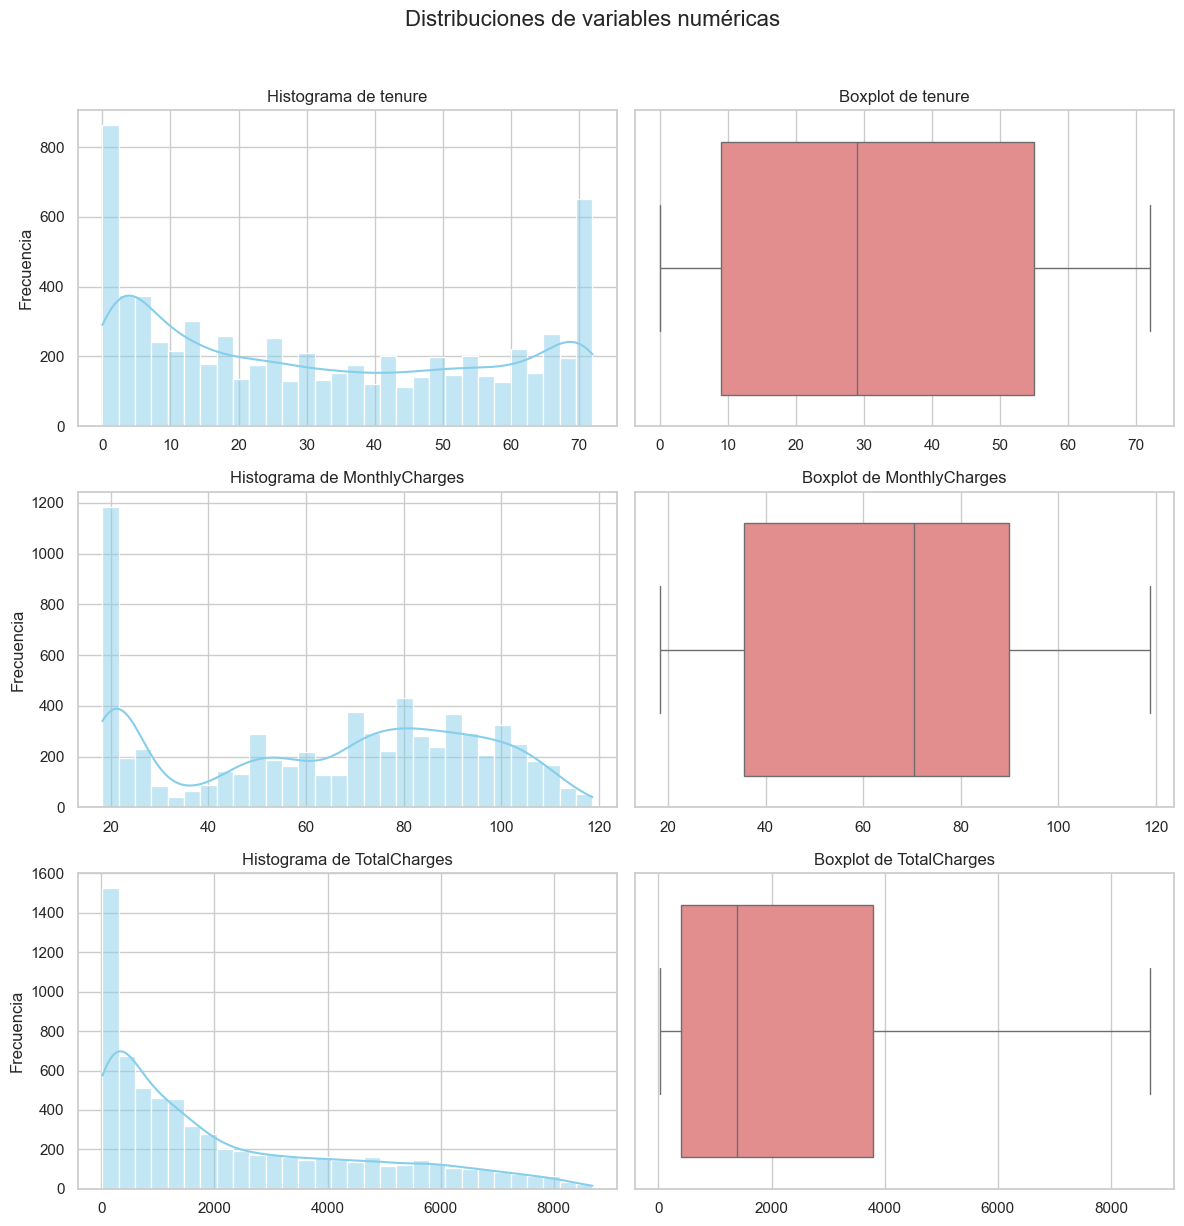

In [20]:
graficar_distribuciones(df,numericas)

Podemos observar que las distribuciones no se asemejan a una normal, ademas podemos observar que no hay outliers en las variables numericas

ahora analizamos las variables categoricas

In [21]:
categoricas=df.select_dtypes(include='object').columns.drop('customerID')

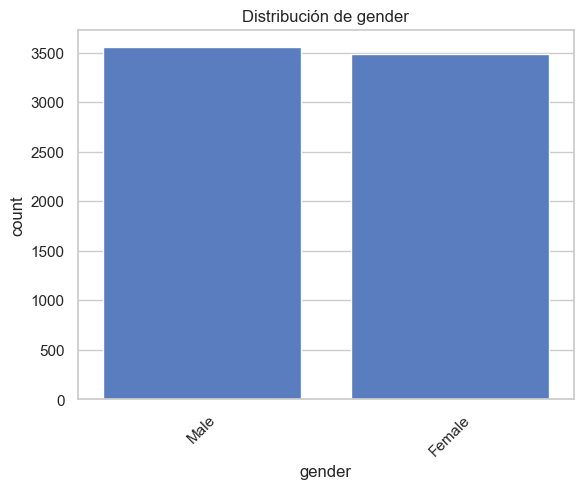

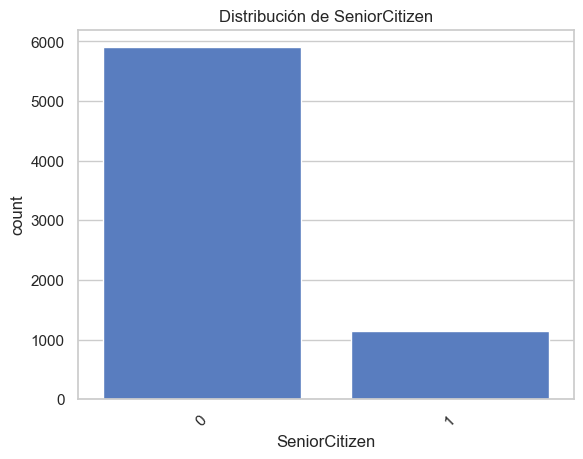

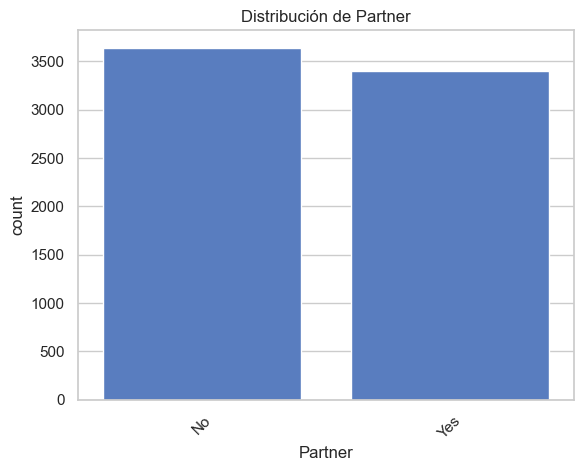

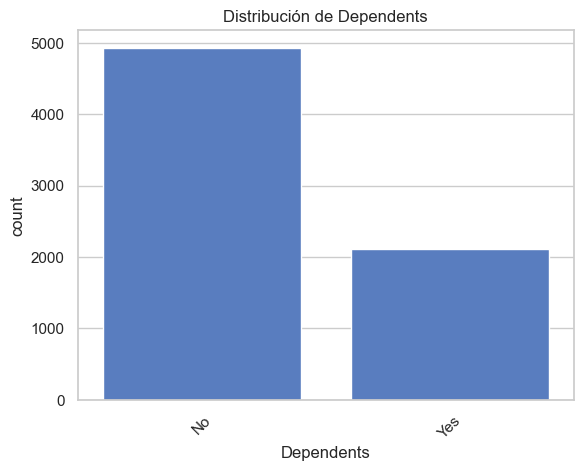

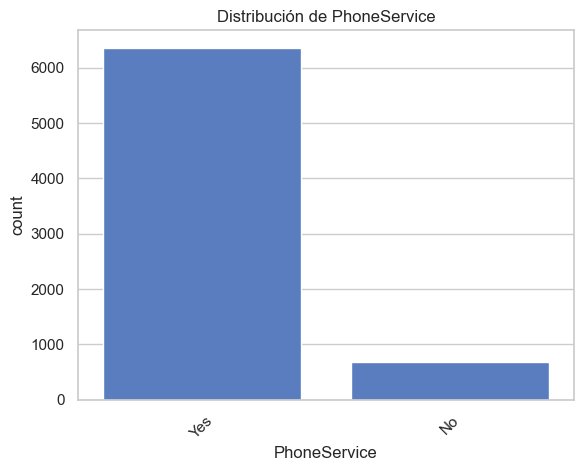

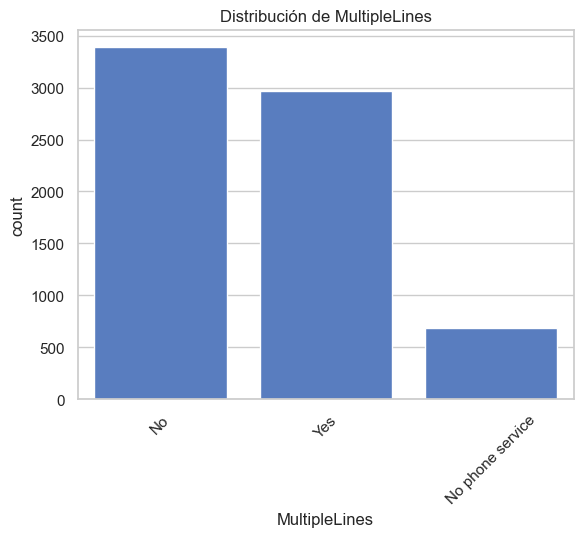

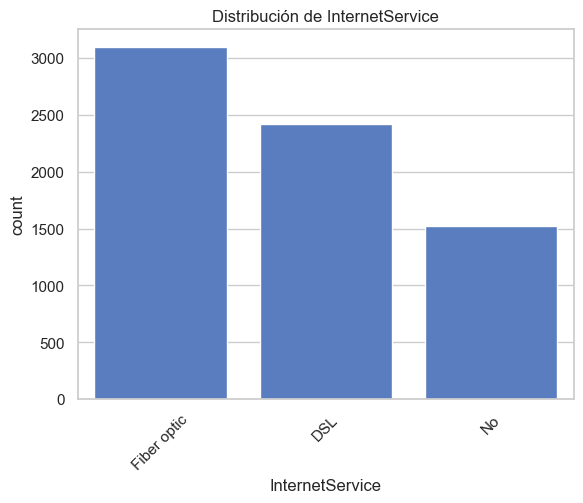

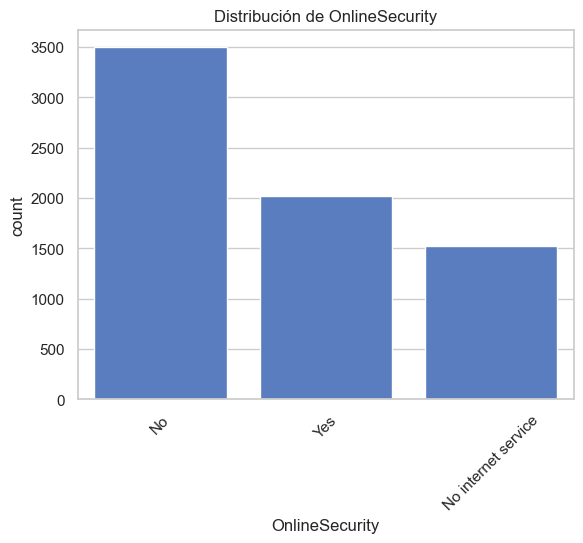

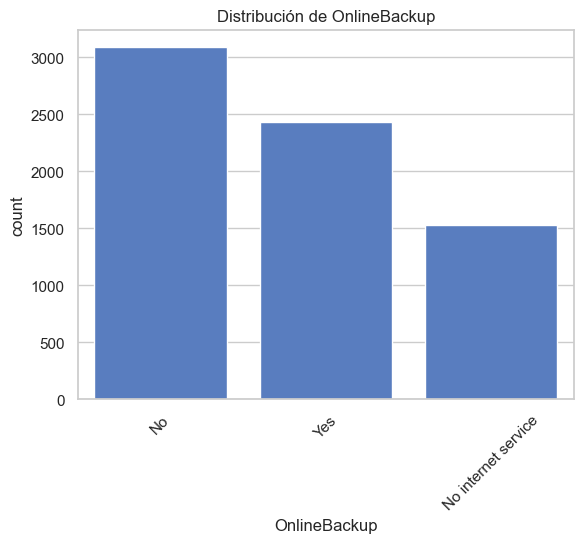

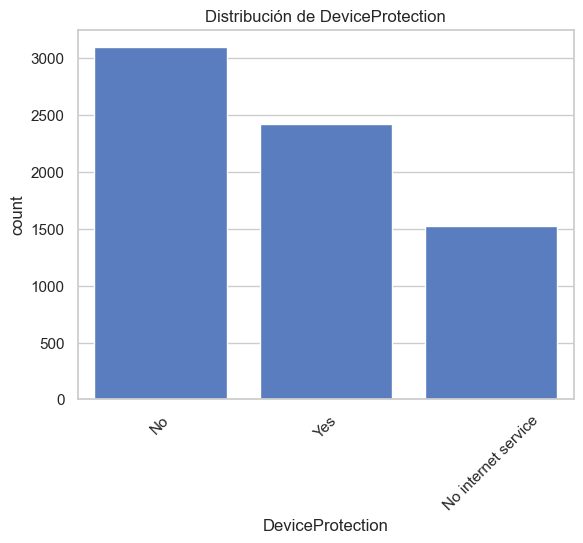

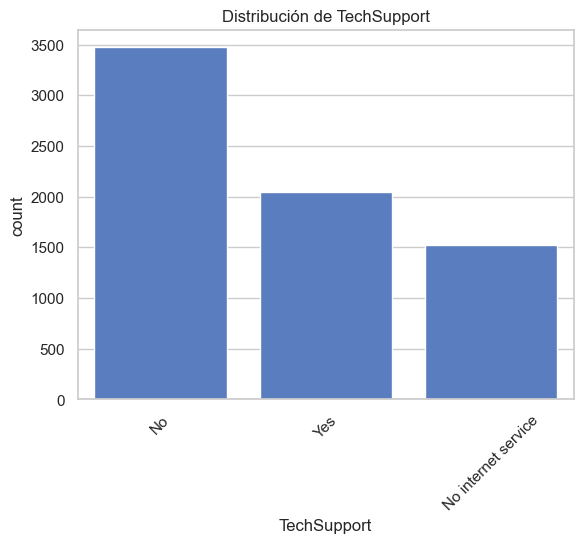

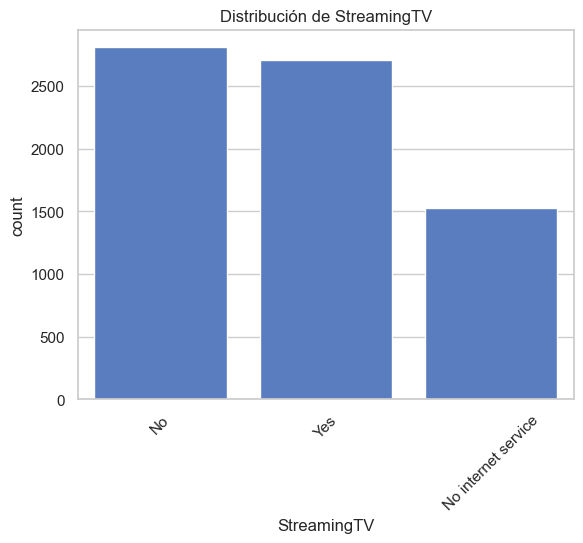

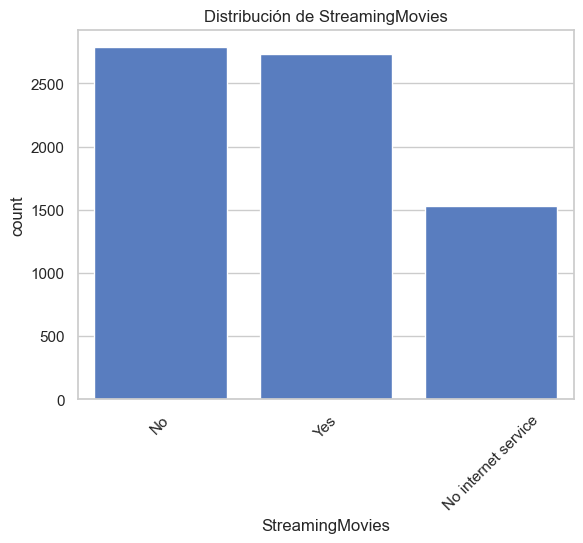

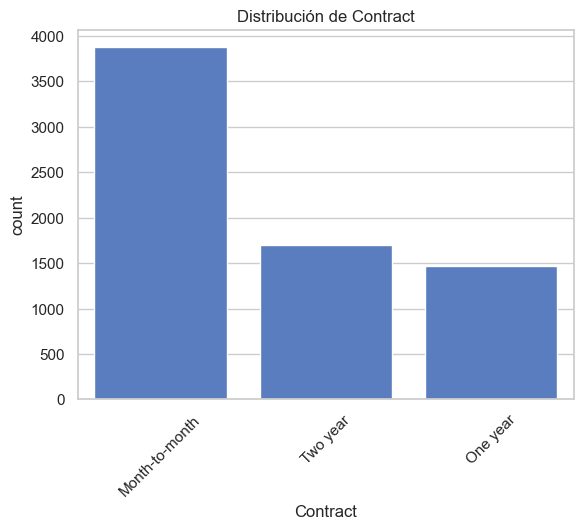

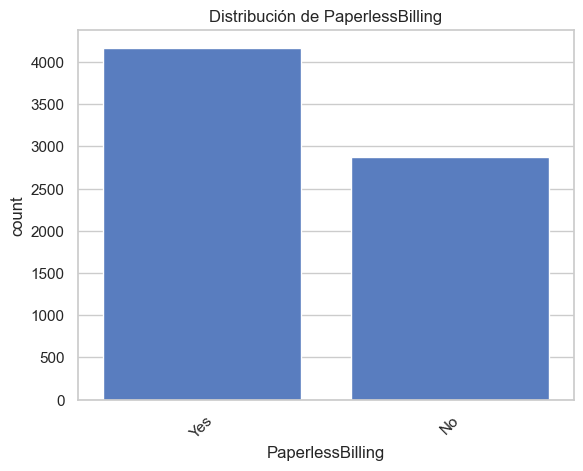

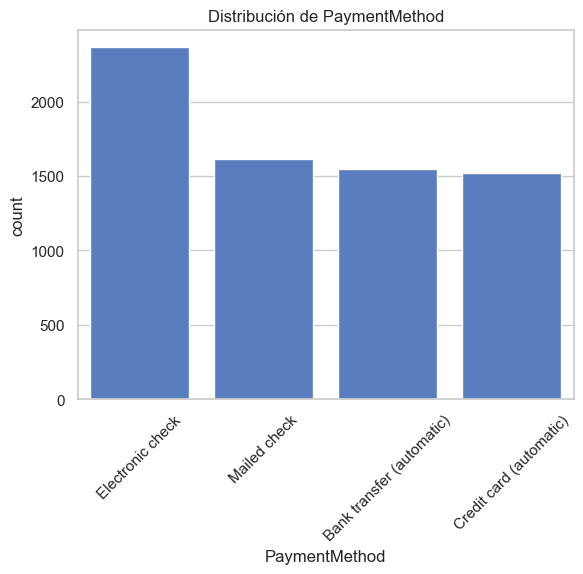

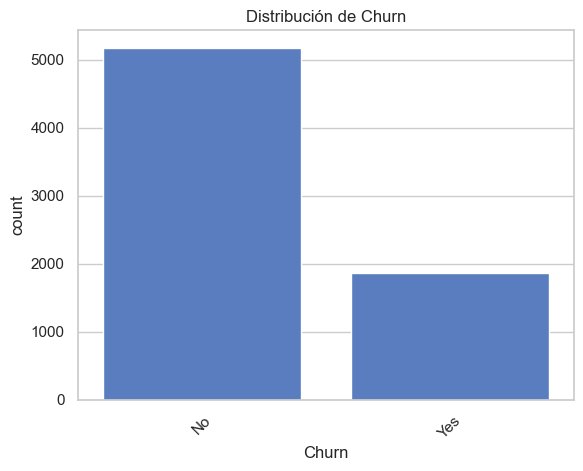

In [22]:
graficar_categoricas(df,categoricas)

Podemos observar las categorias de cada uno de las variables categoricas, tambien podemos observar las categorias de la variable objetivo y vemos que esta desbalanceada, esto se tomara en cuenta a la hora de realizar los modelos

### Analisis Bivariado

realizamos primero el analisis bivariado numerico

In [23]:
prueba_normalidad(df)

,variable,n_muestras,shapiro_p,dagostino_p,ks_p,es_normal (alpha=0.05)
0,tenure,7043,NaN,0.000000e+00,4.439432e-76,False
1,MonthlyCharges,7043,NaN,0.000000e+00,2.976198e-98,False
2,TotalCharges,7032,NaN,9.614342e-176,1.586538e-155,False


===  Correlaciones más altas ===


,Variable 1,Variable 2,Correlación Pearson,Correlación Spearman,Covarianza
1,tenure,TotalCharges,0.825880,0.889177,45950.743236
2,MonthlyCharges,TotalCharges,0.651065,0.638032,44401.333073
0,tenure,MonthlyCharges,0.247900,0.276417,183.196987



=== Correlaciones más bajas ===


,Variable 1,Variable 2,Correlación Pearson,Correlación Spearman,Covarianza
1,tenure,TotalCharges,0.825880,0.889177,45950.743236
2,MonthlyCharges,TotalCharges,0.651065,0.638032,44401.333073
0,tenure,MonthlyCharges,0.247900,0.276417,183.196987


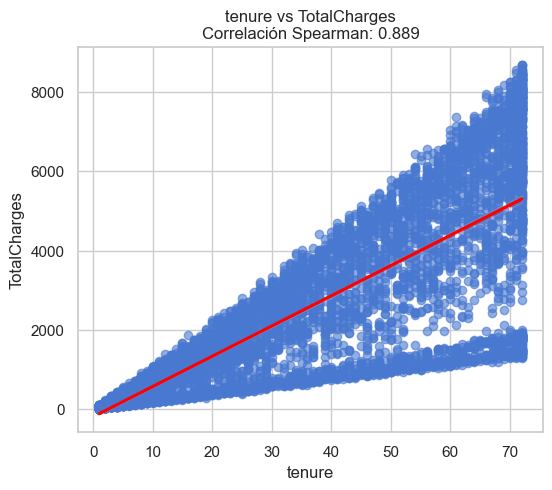

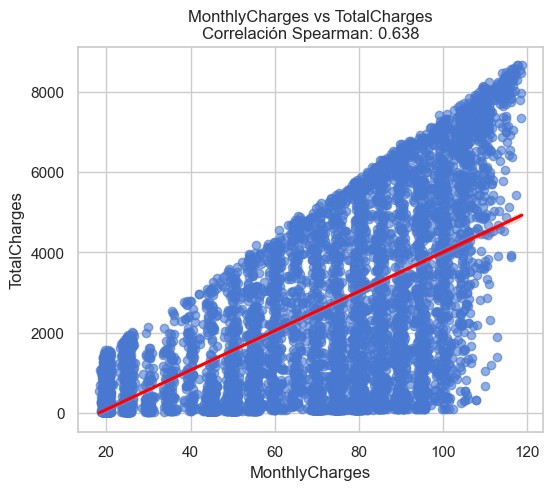

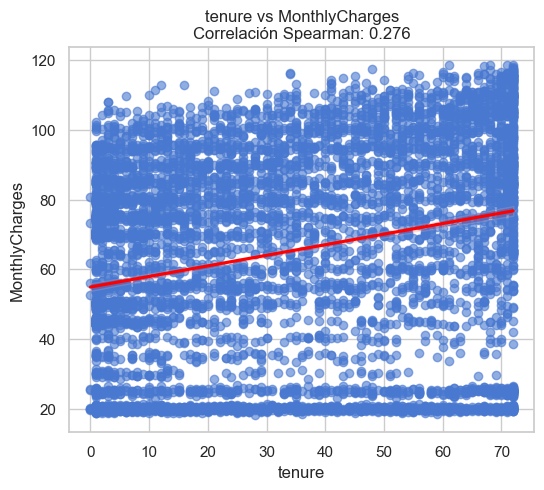

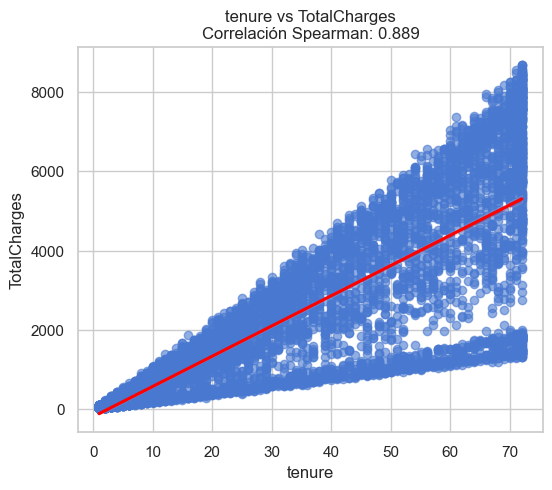

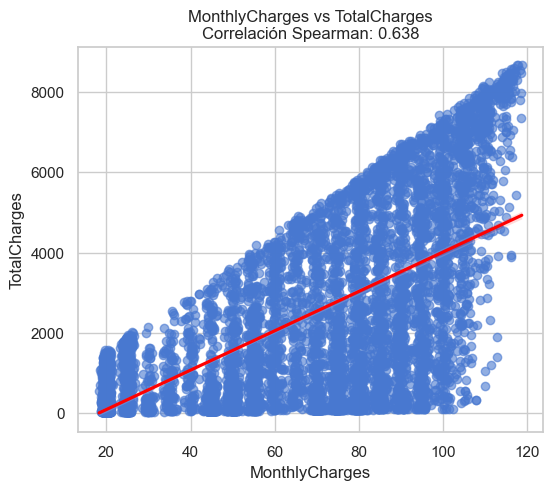

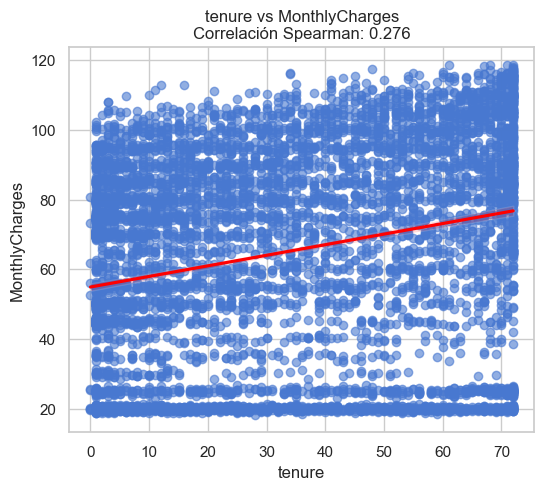

,Variable 1,Variable 2,Correlación Pearson,Correlación Spearman,Covarianza
1,tenure,TotalCharges,0.825880,0.889177,45950.743236
2,MonthlyCharges,TotalCharges,0.651065,0.638032,44401.333073
0,tenure,MonthlyCharges,0.247900,0.276417,183.196987


In [24]:
analisis_bivariado_numerico(df,top=5,mostrar_graficos=True)

Podemos observar que tenure y total charges tienen la correlacion mas alta con 0.8259 en pearson y 0.8892 en spearman lo que significa que clientes con mayor tiempo en la empresa han acumulado más cargos totales.
Monthlycharges y Totalcharges tiene una correlacion menor con 0.6511 y 0.6380 respectivamente lo que muestra que clientes con cargos mensuales altos tienden a tener cargos totales altos, pero no tanto como la permanencia. 
tenure y Monthlycharges lo que significa que los clientes más antiguos no necesariamente pagan más por mes.

Ahora realizamos el analisis bivariado de categoricas

=== Relaciones categóricas más significativas (menor valor p) ===


,Variable 1,Variable 2,Chi-cuadrado,Grados de libertad,Valor p,V de Cramer
0,PhoneService,InternetService,1441.623387,2,0.0,0.452144
1,OnlineBackup,StreamingMovies,7174.586977,4,0.0,0.713584
2,OnlineBackup,StreamingTV,7195.057831,4,0.0,0.714602
3,MultipleLines,InternetService,2217.014120,4,0.0,0.396424
4,OnlineBackup,DeviceProtection,7284.450039,4,0.0,0.719030



=== Relaciones menos significativas ===


,Variable 1,Variable 2,Chi-cuadrado,Grados de libertad,Valor p,V de Cramer
148,gender,Partner,0.016356,1,0.898234,0.0
149,gender,SeniorCitizen,0.015604,1,0.900589,0.0
150,Dependents,PhoneService,0.010788,1,0.917277,0.0
151,PhoneService,Contract,0.111346,2,0.945848,0.0
152,Partner,InternetService,0.005798,2,0.997105,0.0



Gráficos de las relaciones más significativas:

PhoneService vs InternetService (p = 0.0000, V de Cramer = 0.452)


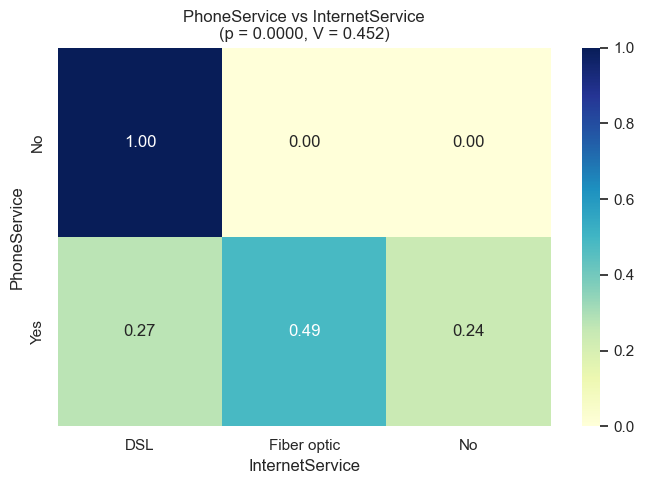


OnlineBackup vs StreamingMovies (p = 0.0000, V de Cramer = 0.714)


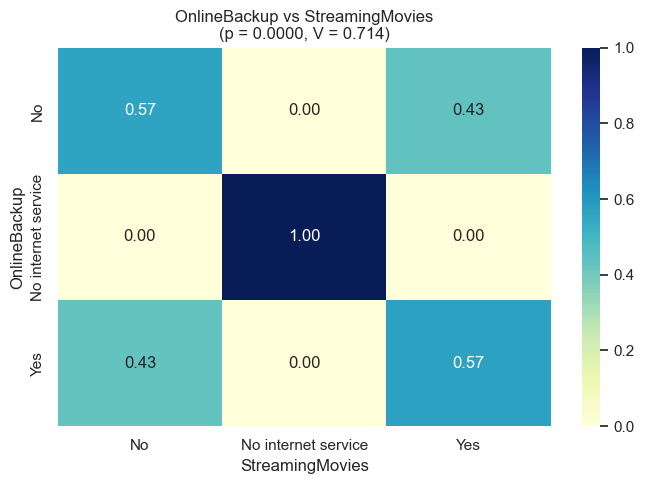


OnlineBackup vs StreamingTV (p = 0.0000, V de Cramer = 0.715)


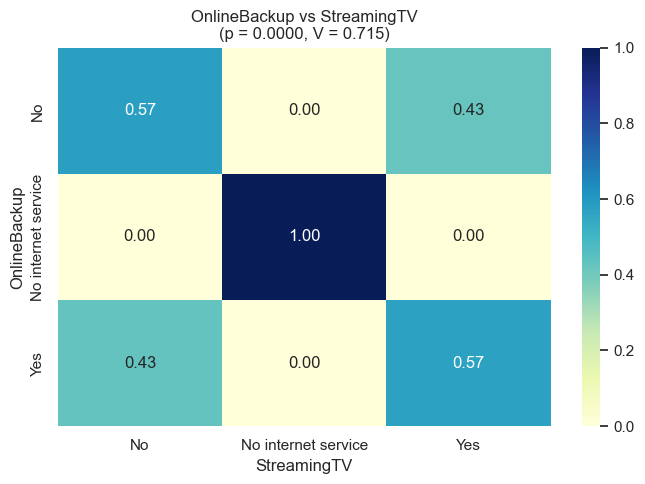


MultipleLines vs InternetService (p = 0.0000, V de Cramer = 0.396)


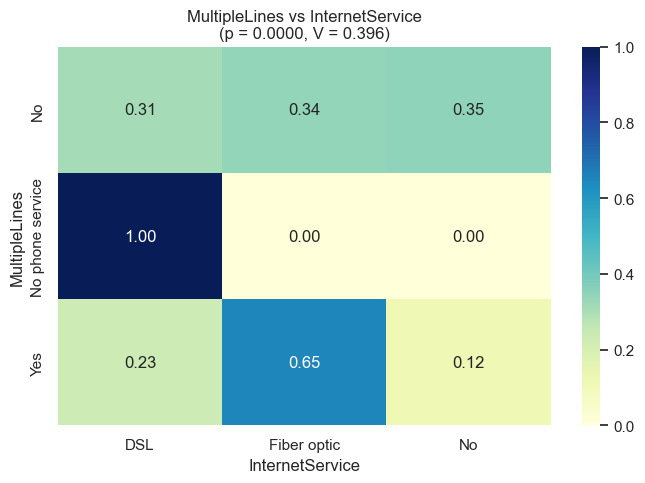


OnlineBackup vs DeviceProtection (p = 0.0000, V de Cramer = 0.719)


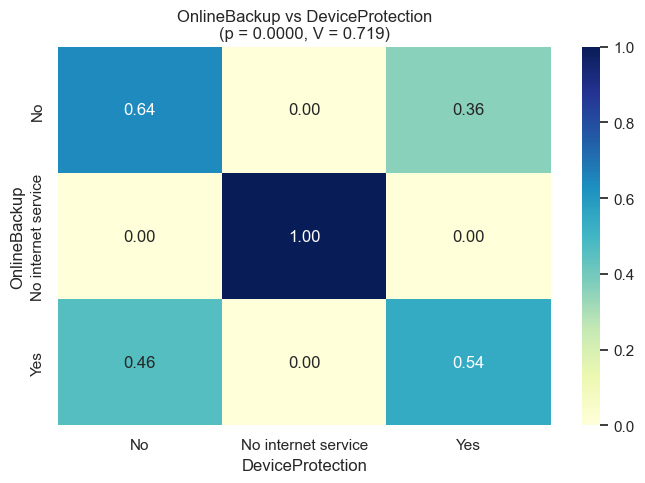

,Variable 1,Variable 2,Chi-cuadrado,Grados de libertad,Valor p,V de Cramer
0,PhoneService,InternetService,1441.623387,2,0.000000,0.452144
1,OnlineBackup,StreamingMovies,7174.586977,4,0.000000,0.713584
2,OnlineBackup,StreamingTV,7195.057831,4,0.000000,0.714602
3,MultipleLines,InternetService,2217.014120,4,0.000000,0.396424
4,OnlineBackup,DeviceProtection,7284.450039,4,0.000000,0.719030
...,...,...,...,...,...,...
148,gender,Partner,0.016356,1,0.898234,0.000000
149,gender,SeniorCitizen,0.015604,1,0.900589,0.000000
150,Dependents,PhoneService,0.010788,1,0.917277,0.000000
151,PhoneService,Contract,0.111346,2,0.945848,0.000000


In [25]:
analisis_bivariado_categorico(df,top=5,mostrar_graficos=True)

Podemos observar que las relaciones que son significativas y mas fuertes son principalmente las que tienen que ver con los servicios telefonicos y los servicios de internet con p-valores muy bajos y cramer alto

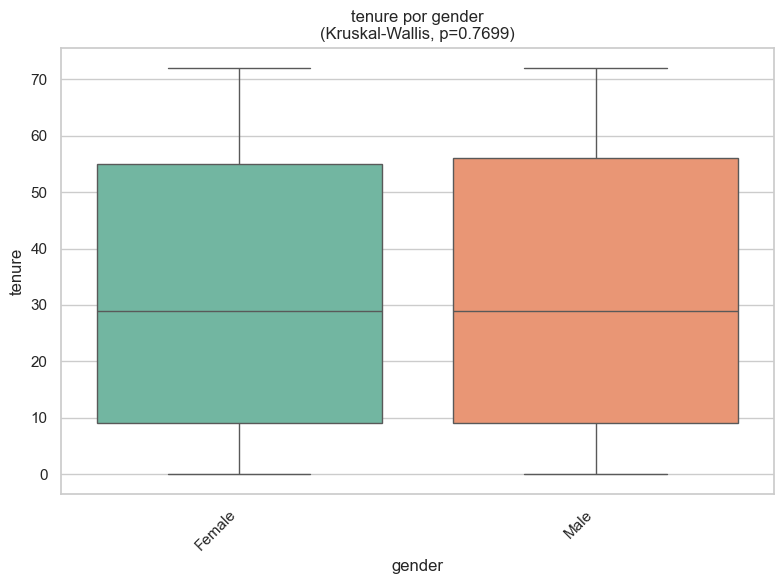

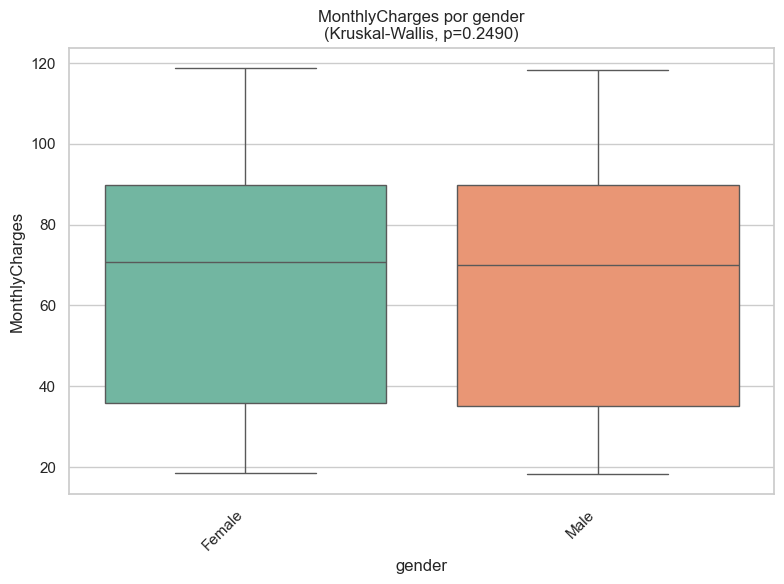

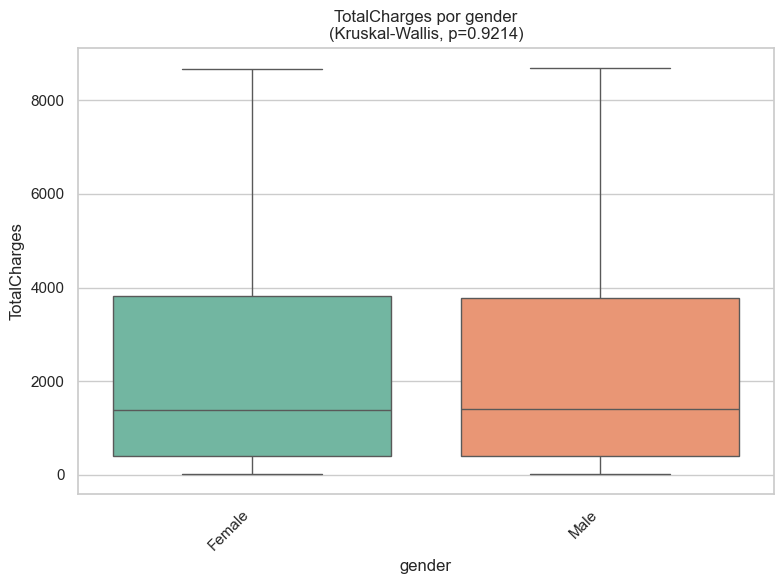

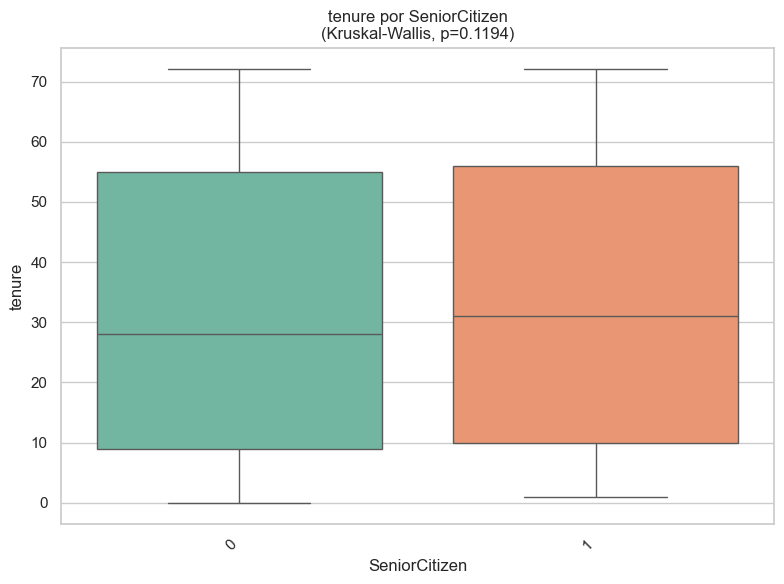

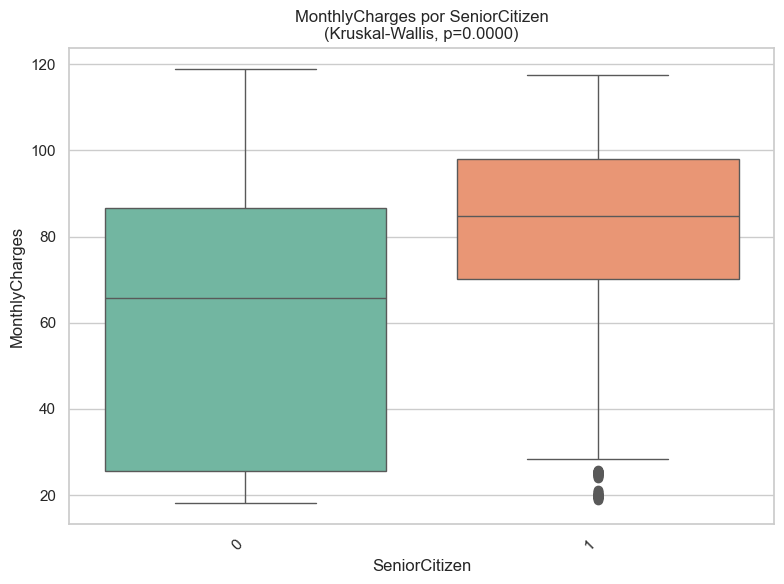

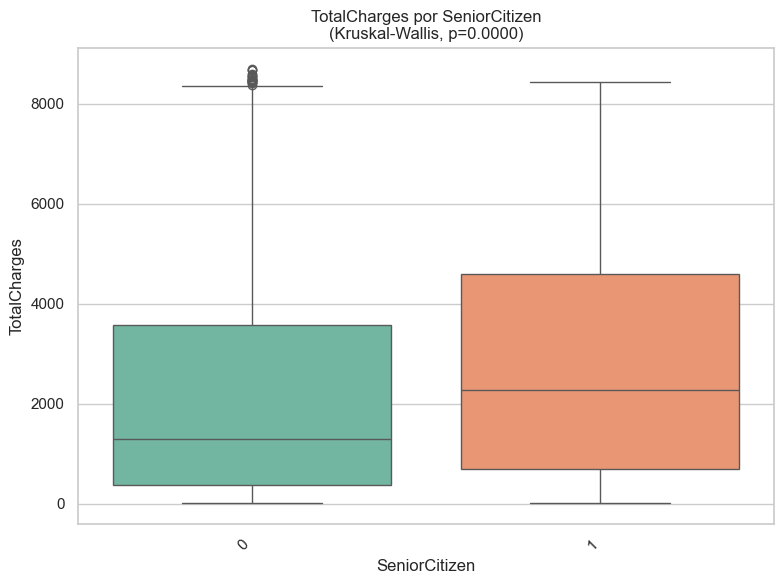

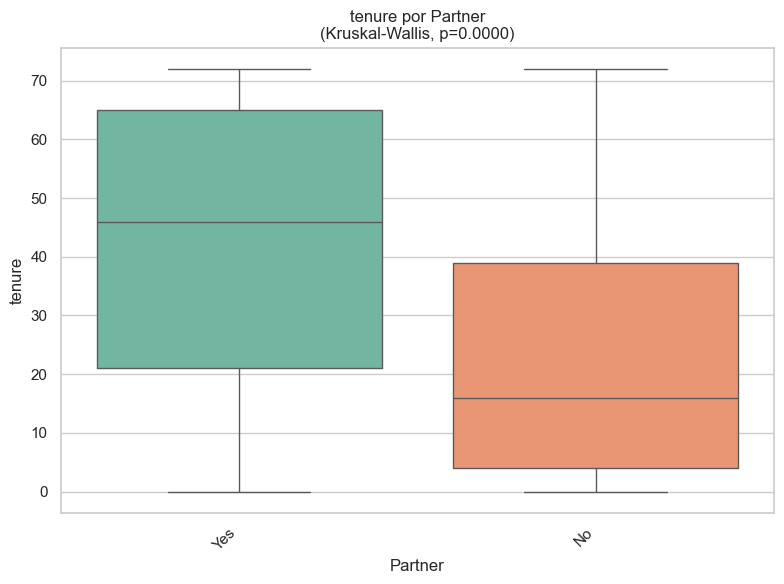

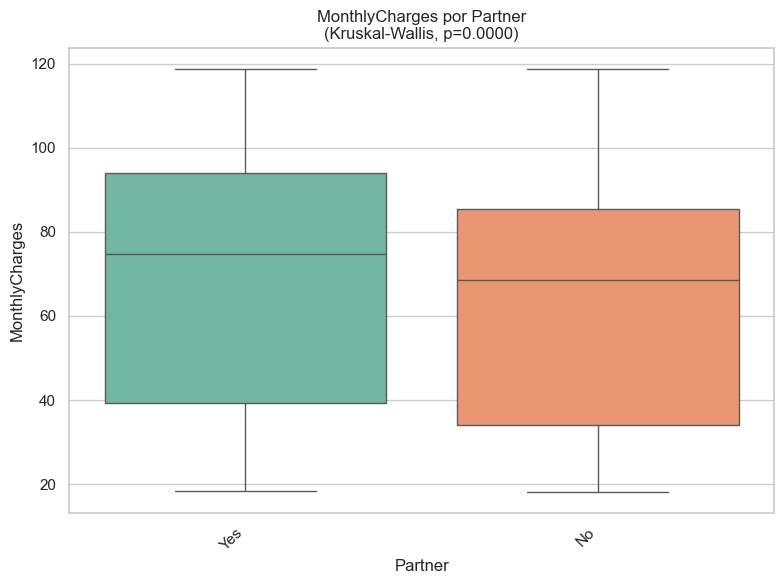

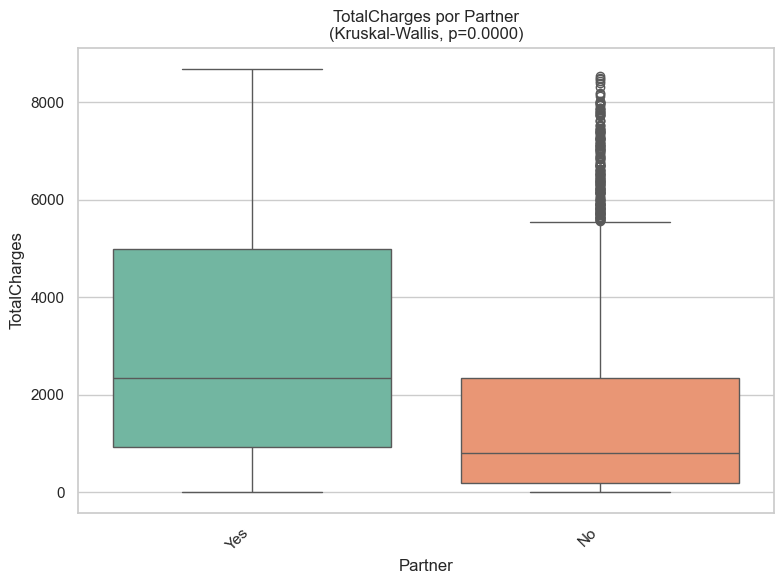

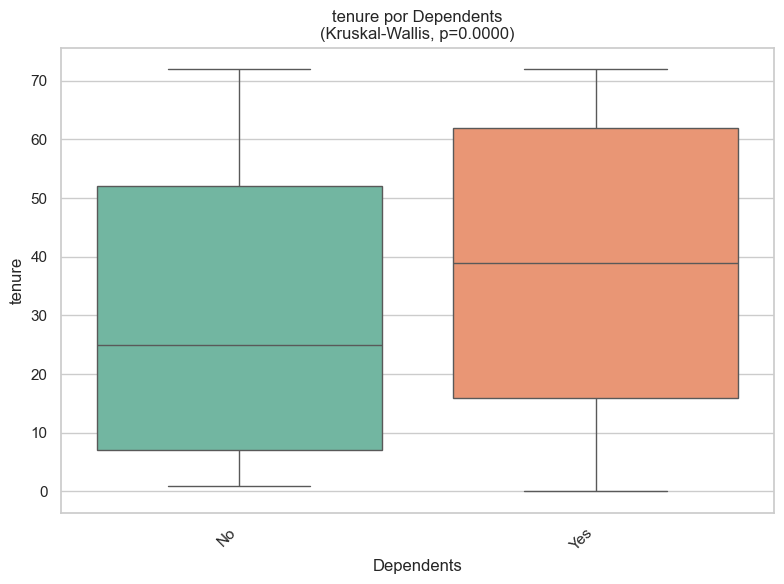

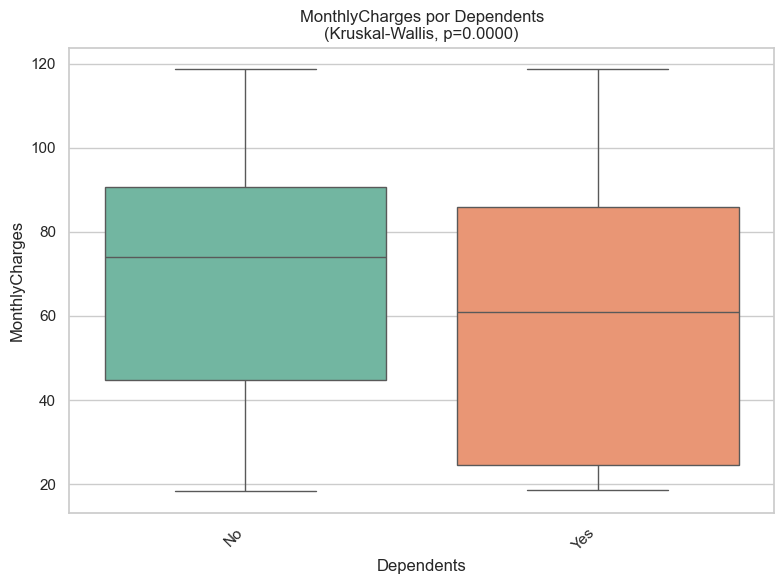

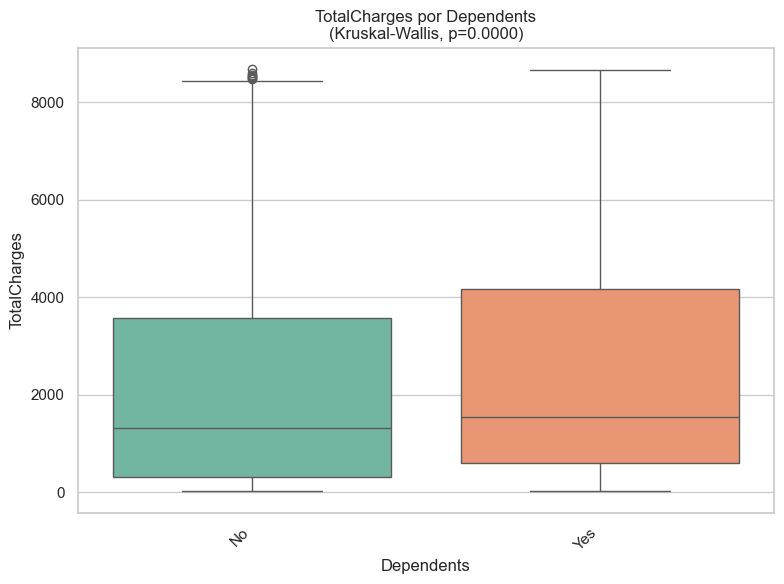

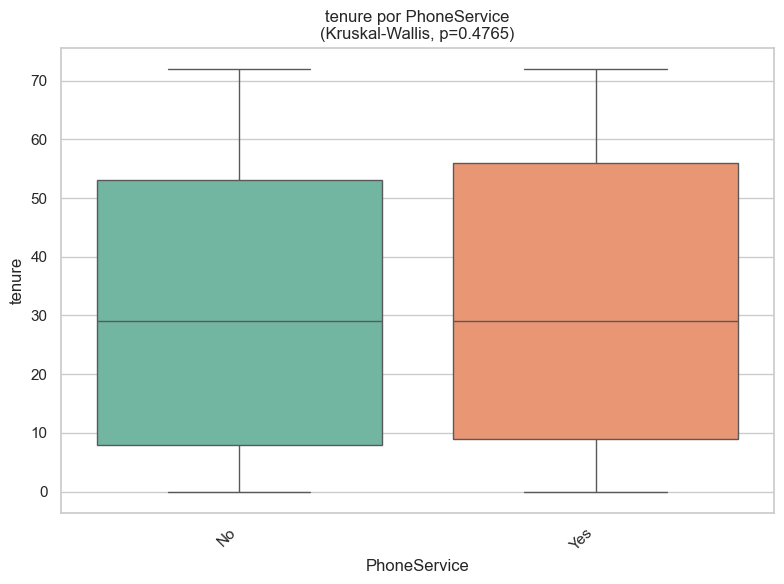

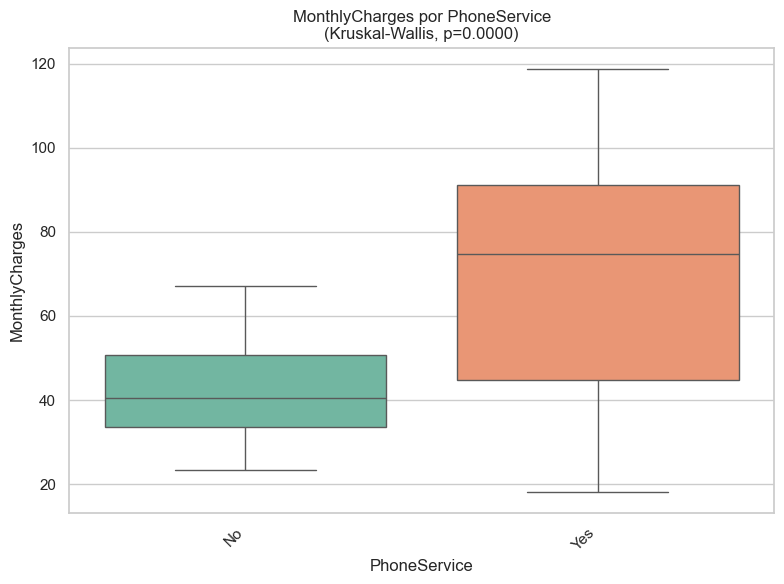

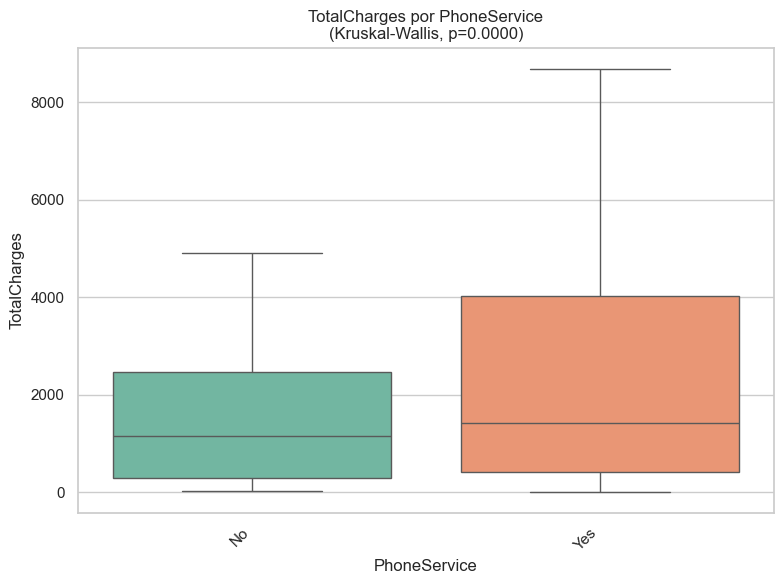

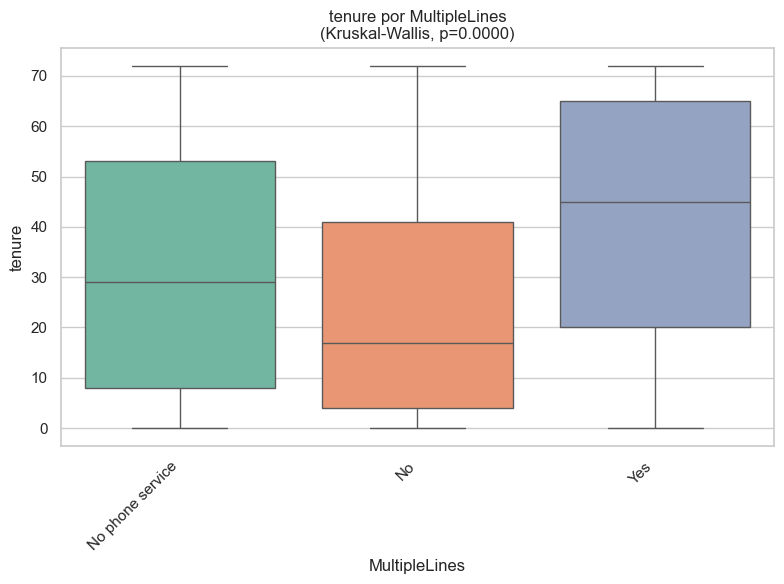

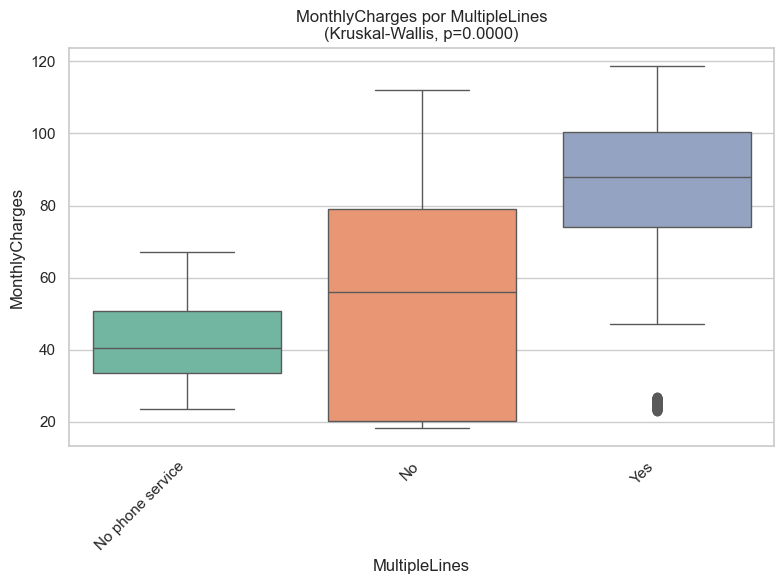

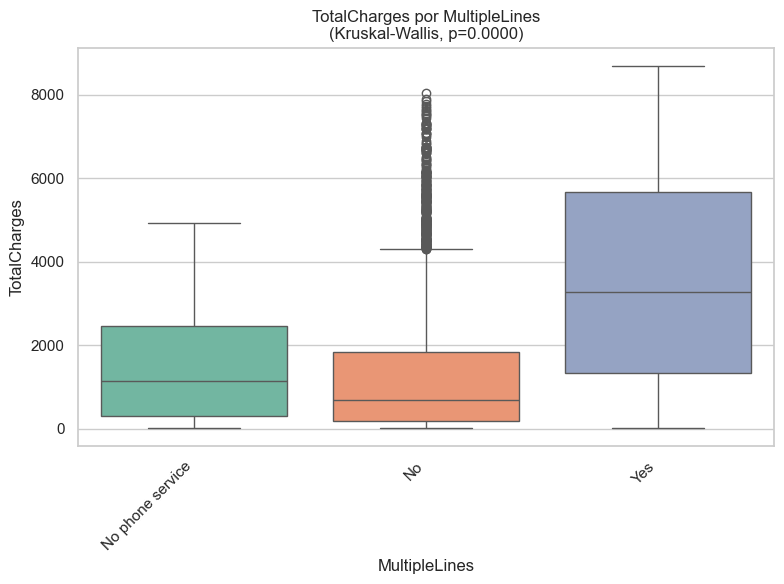

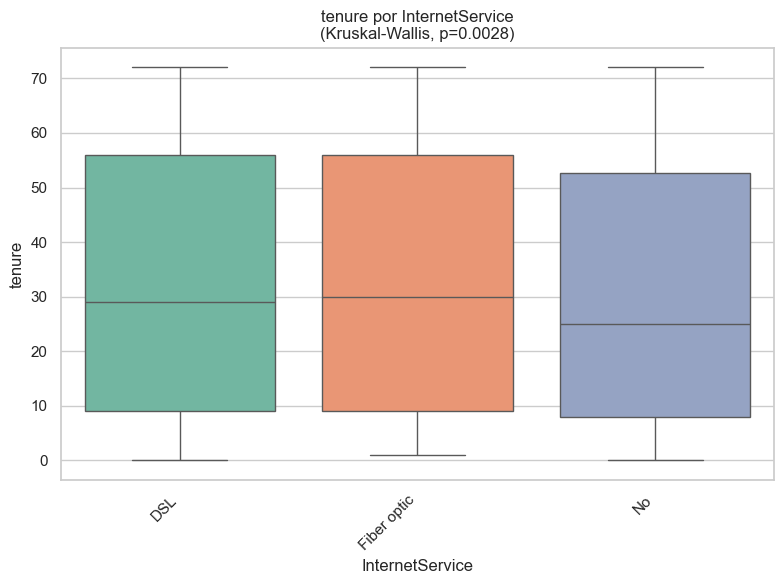

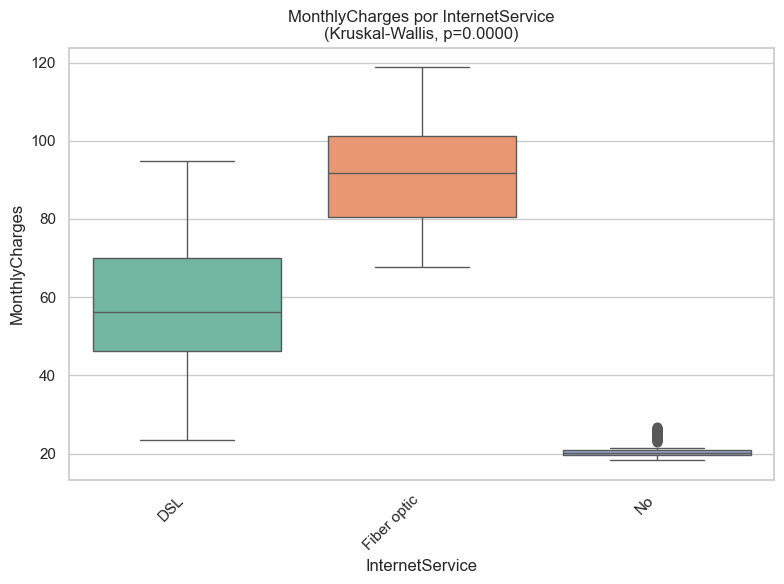

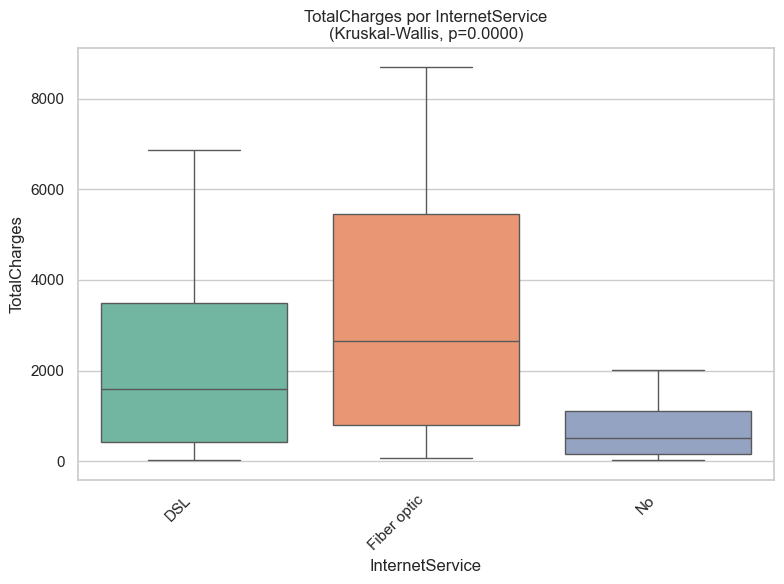

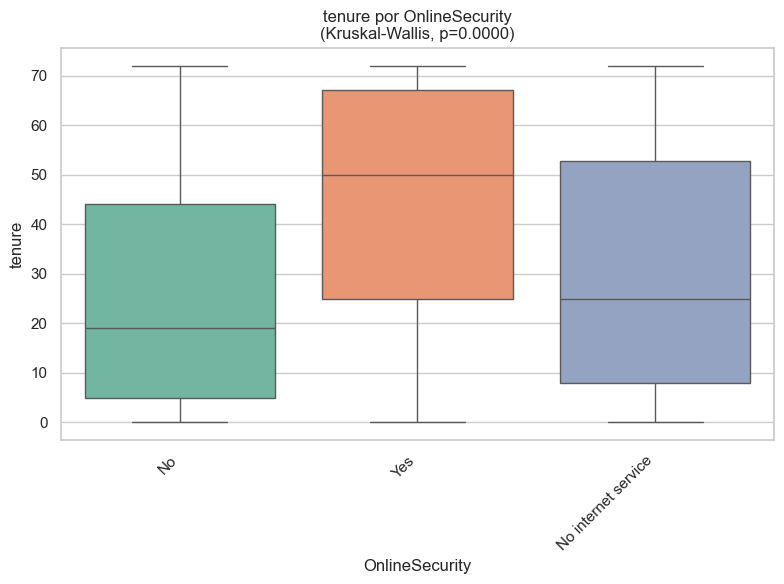

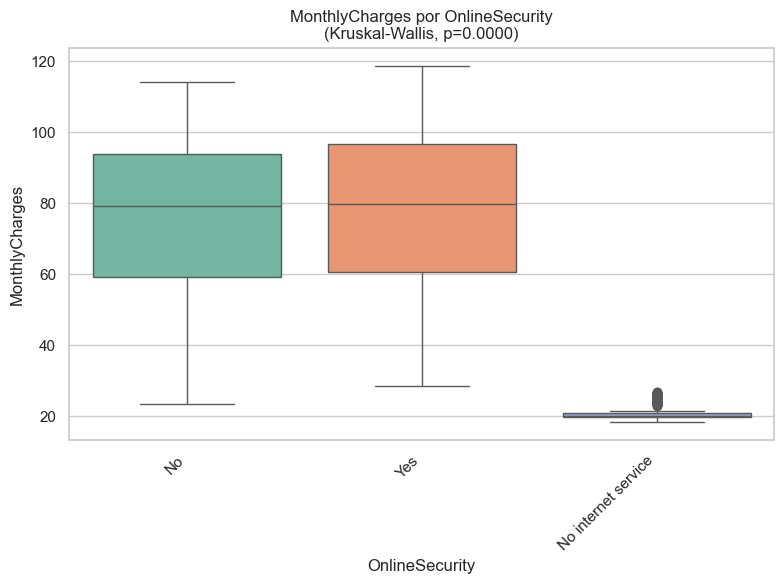

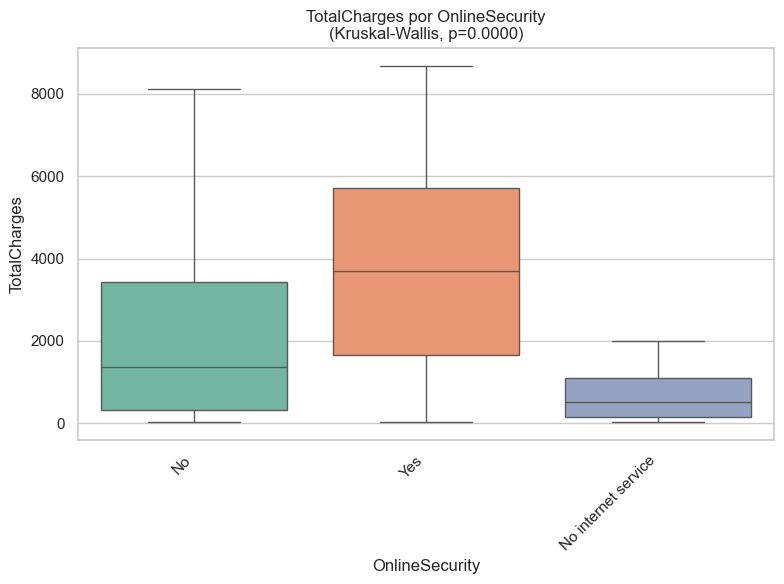

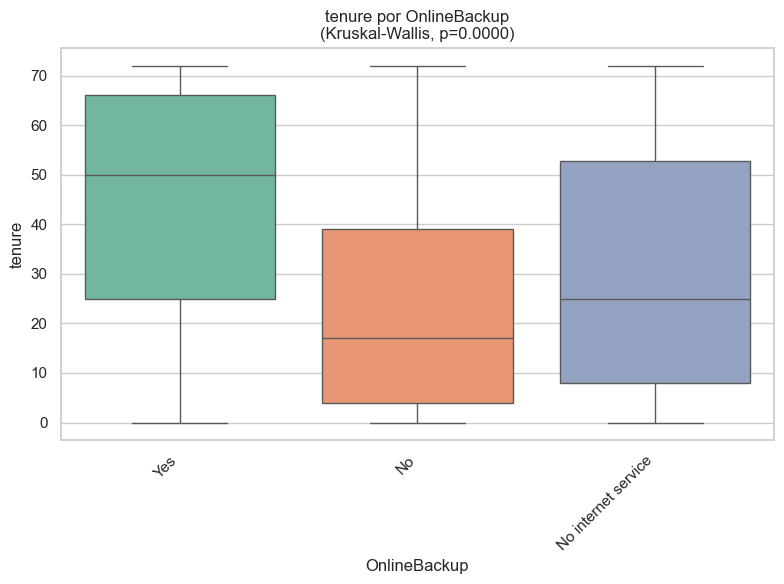

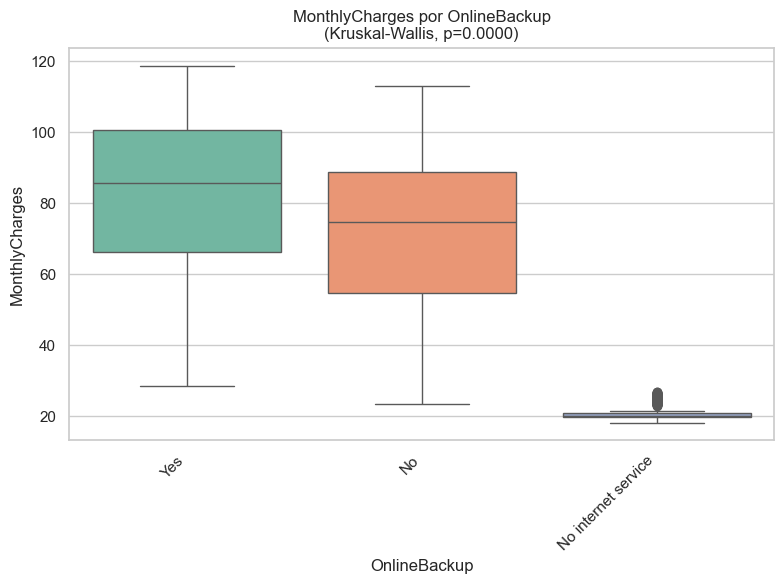

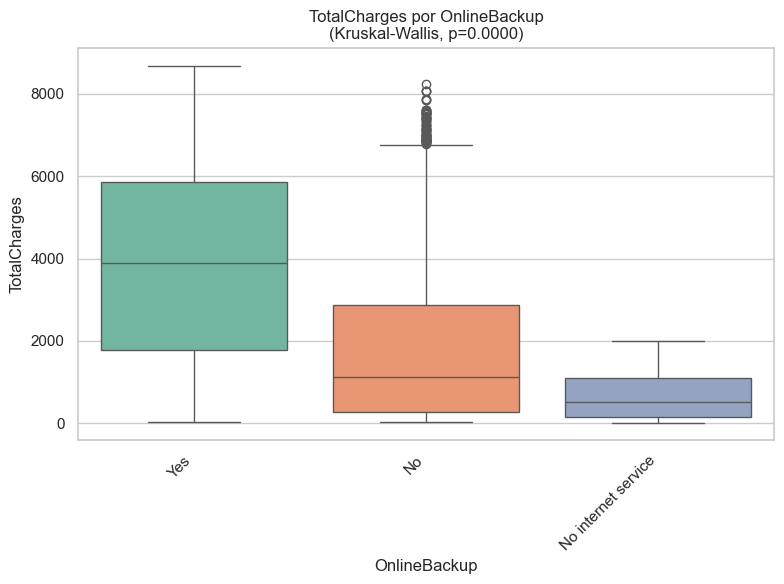

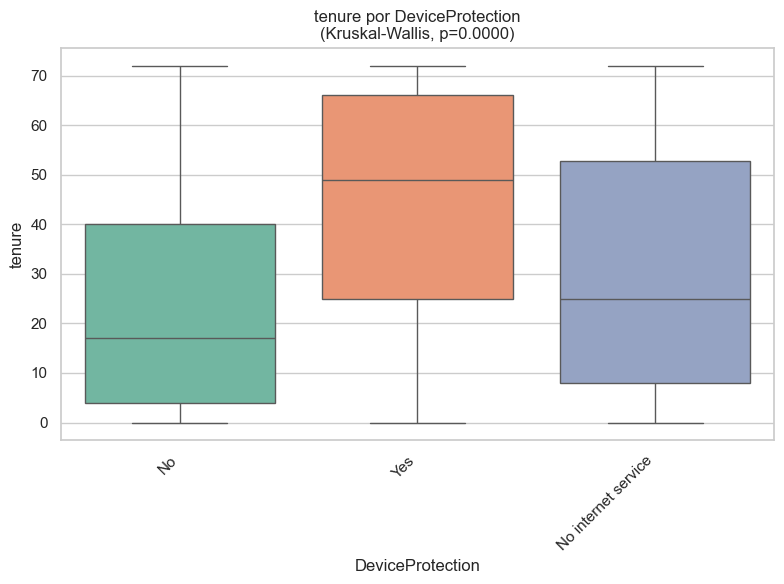

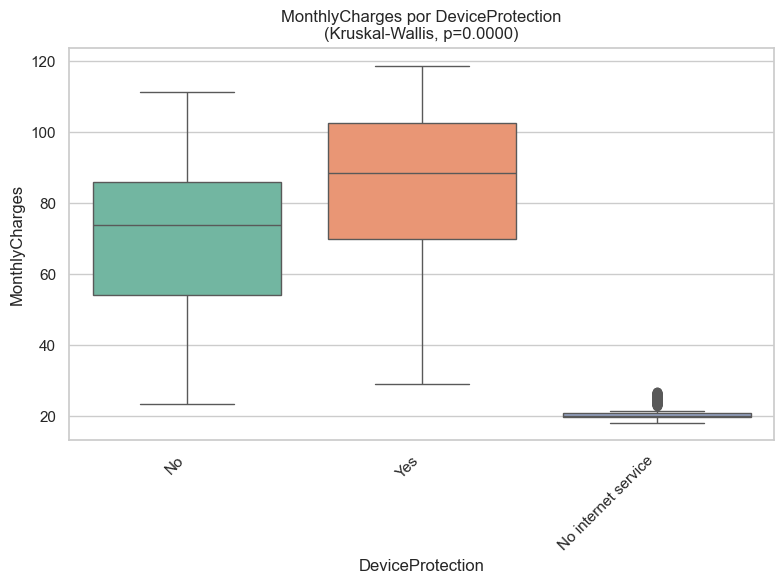

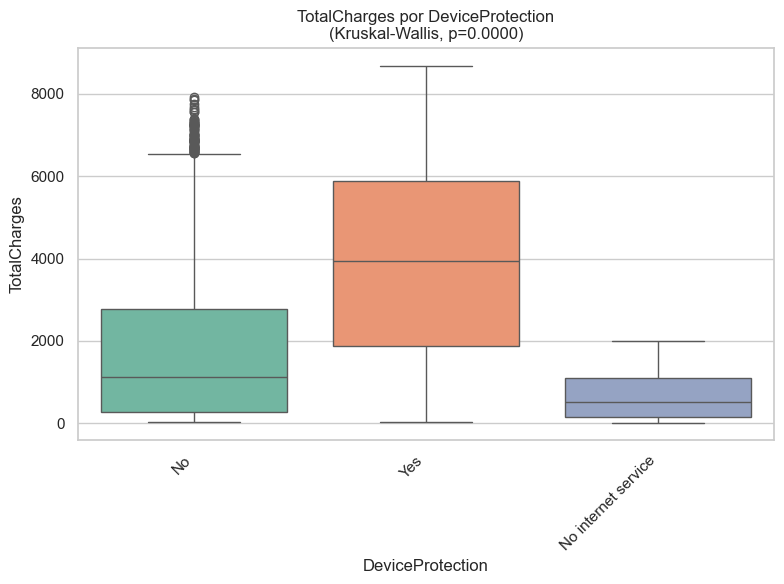

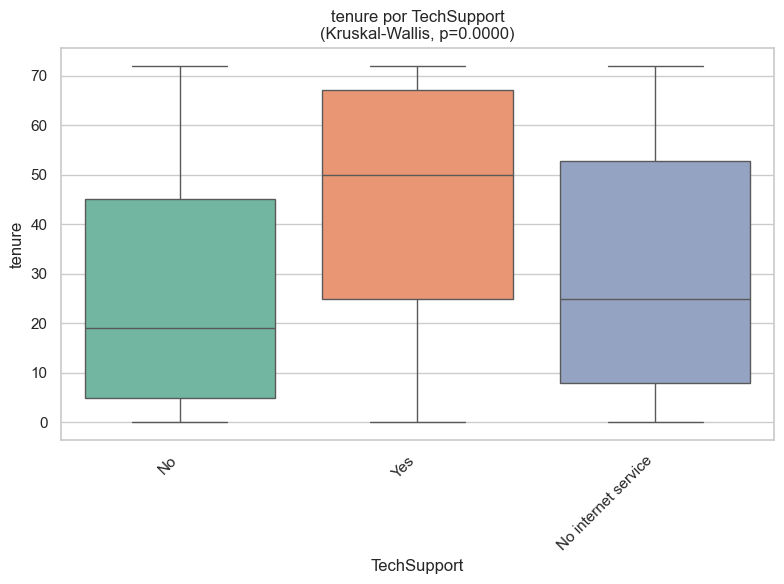

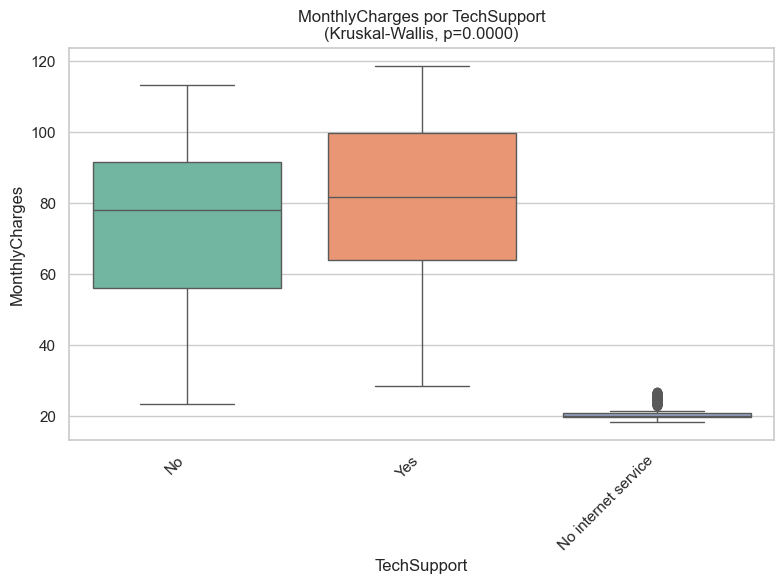

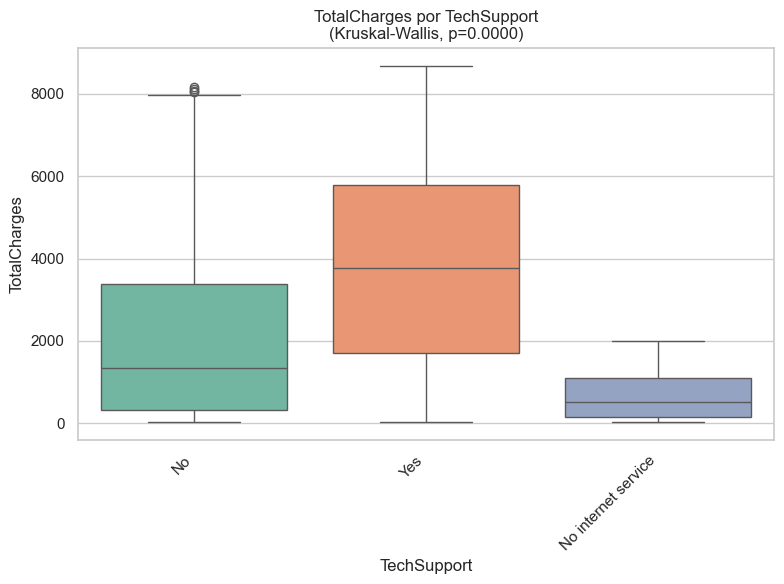

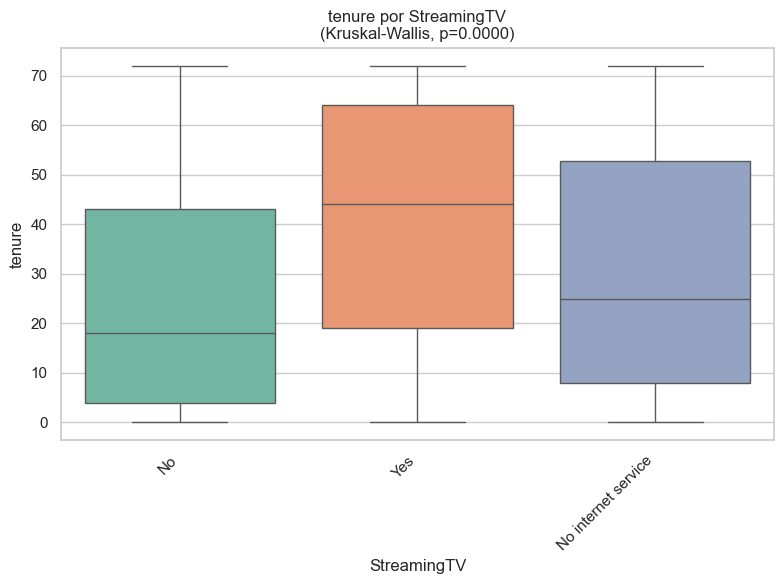

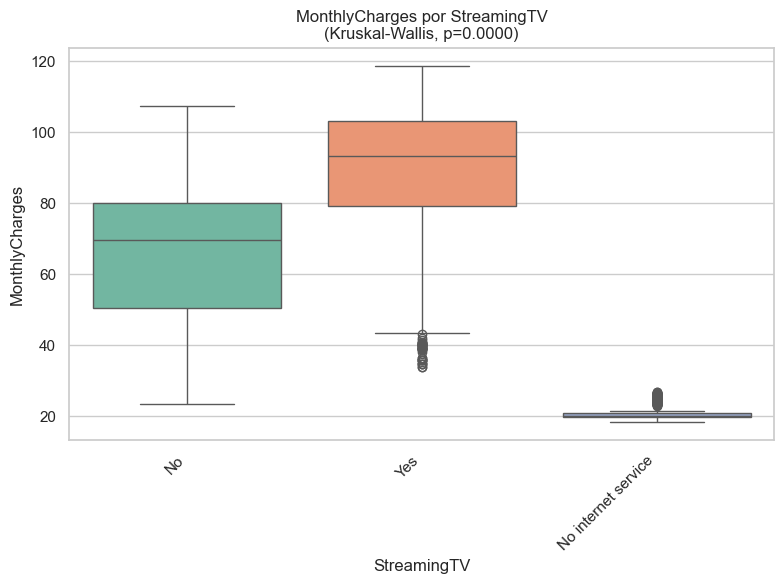

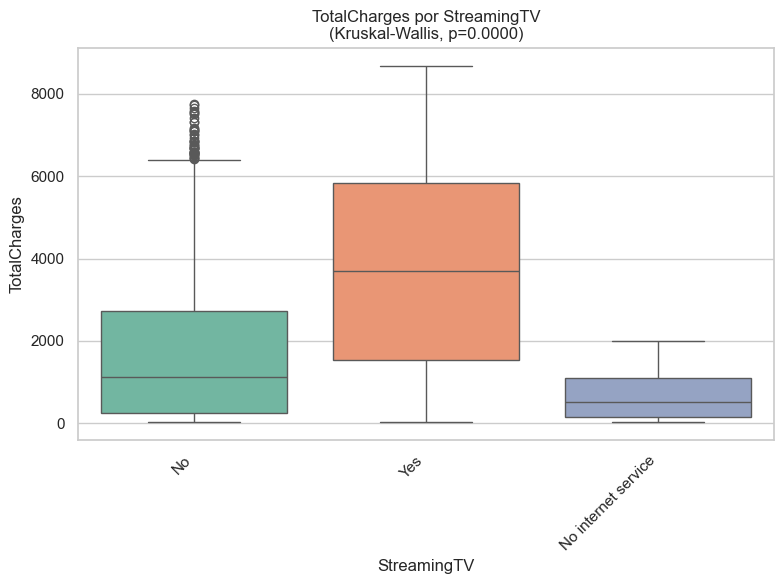

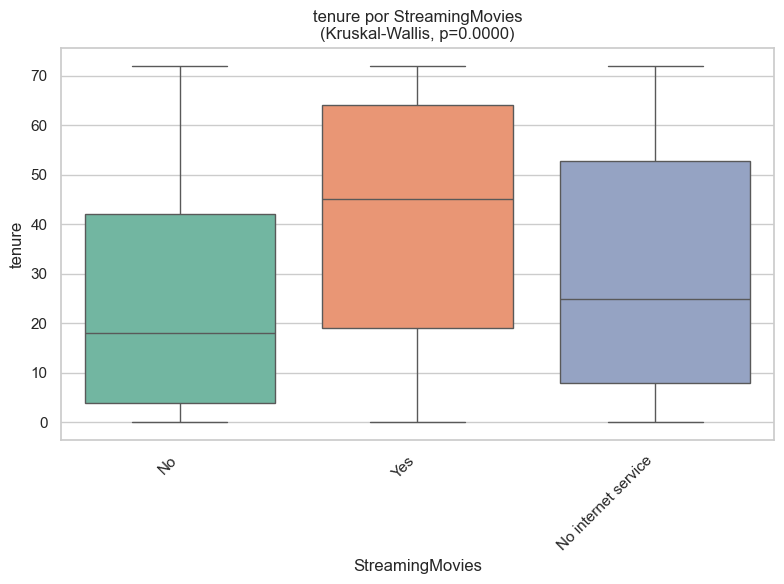

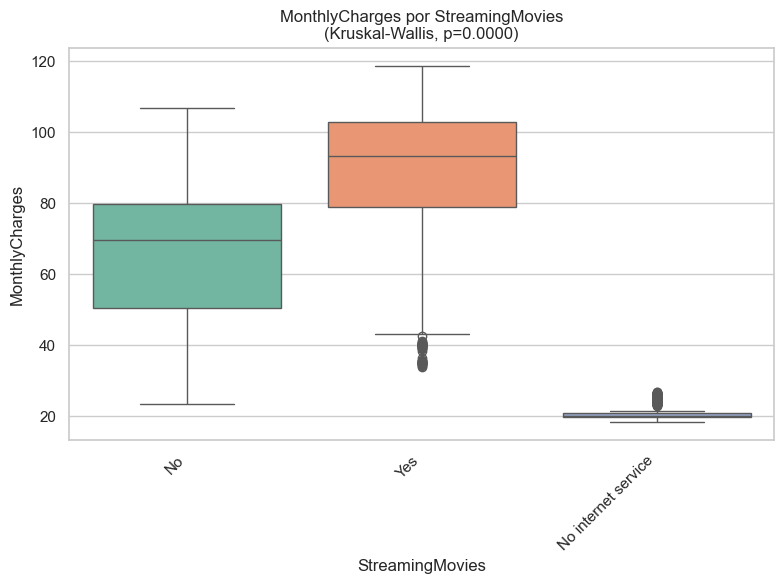

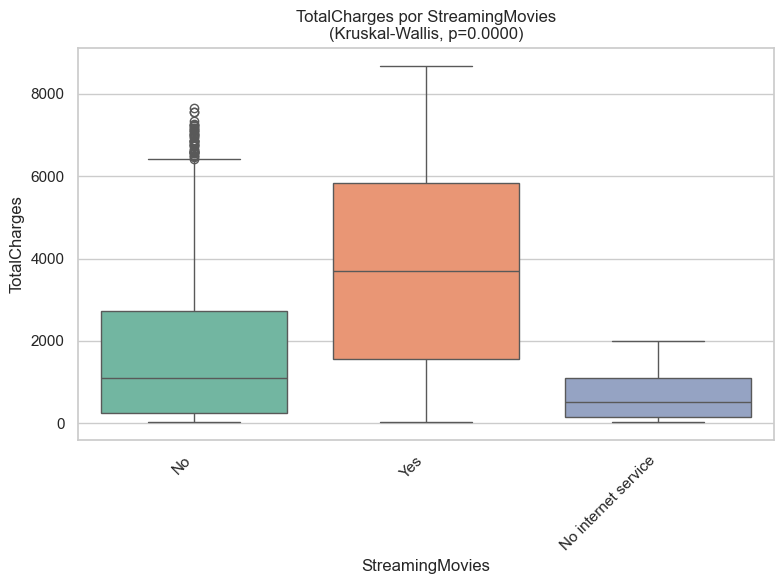

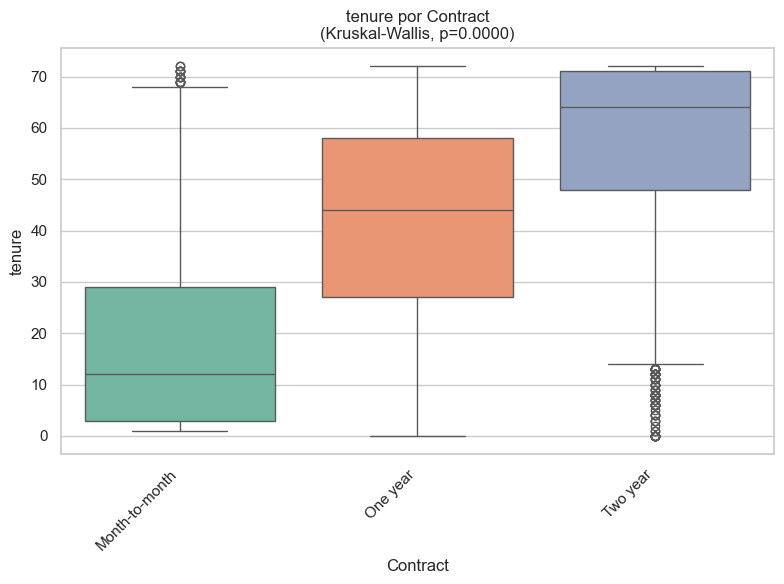

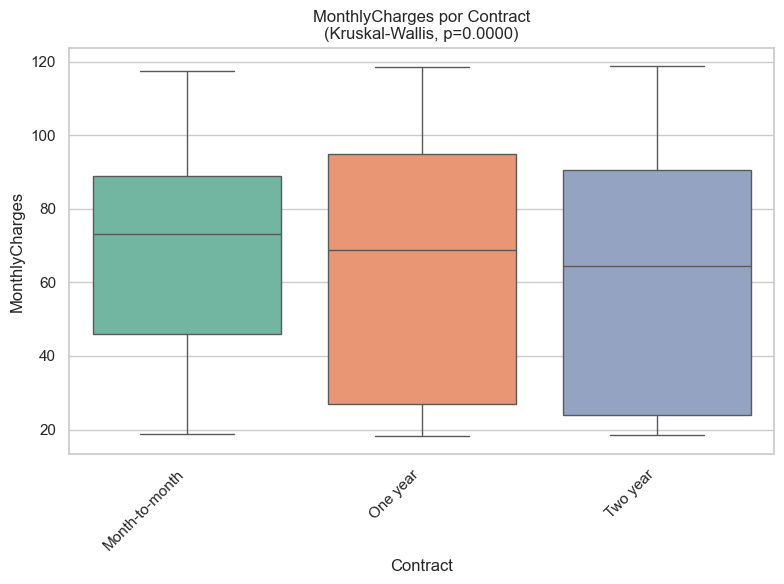

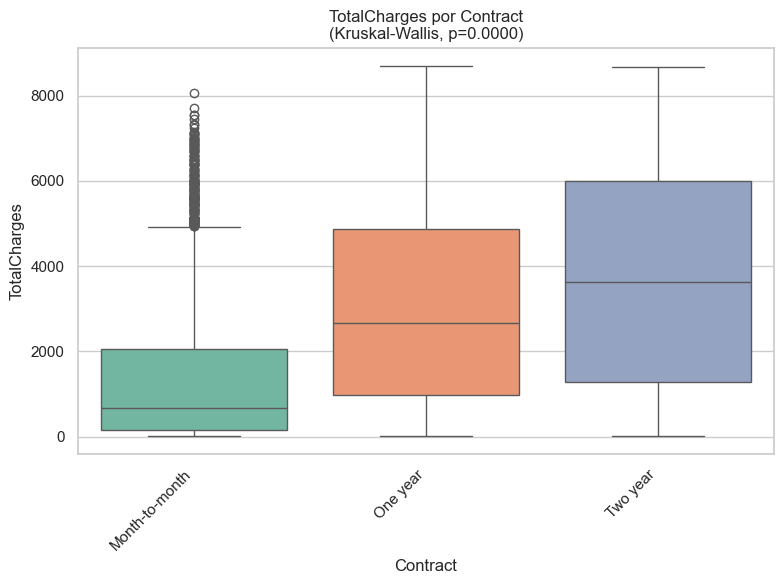

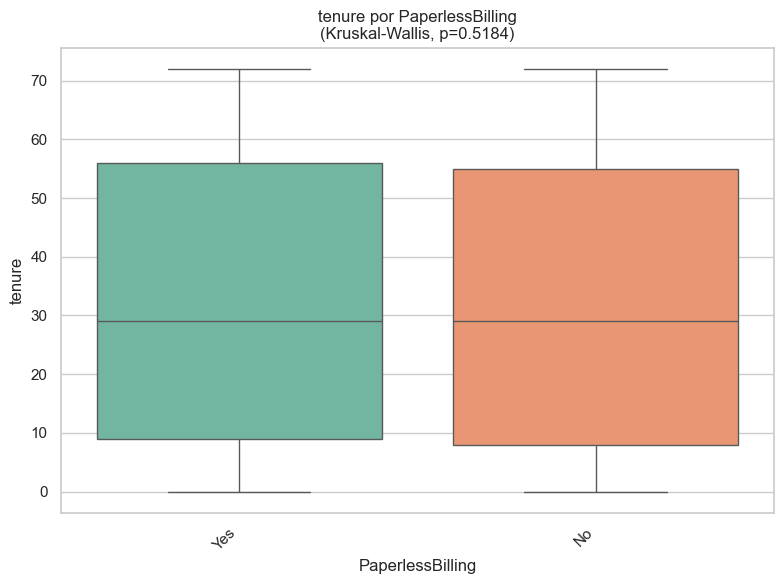

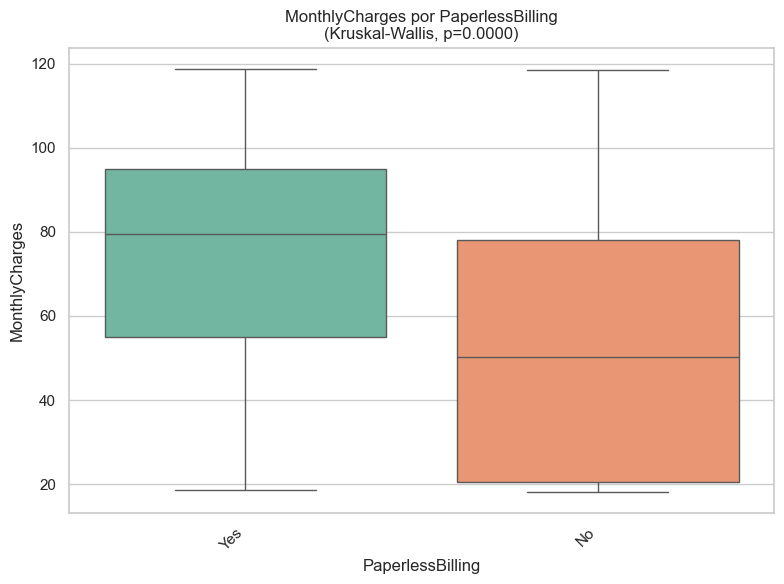

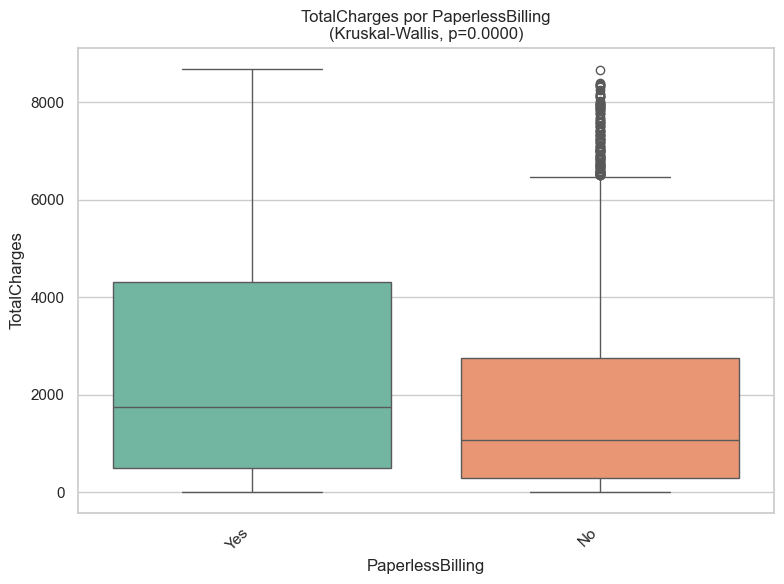

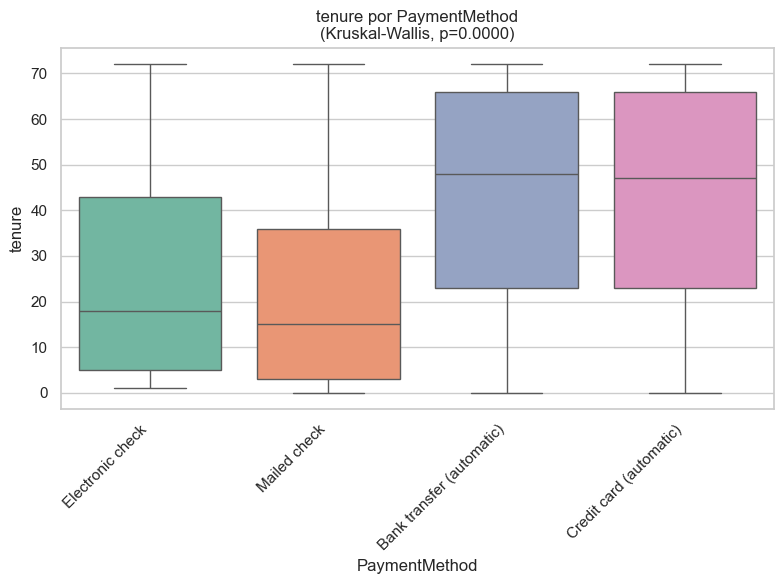

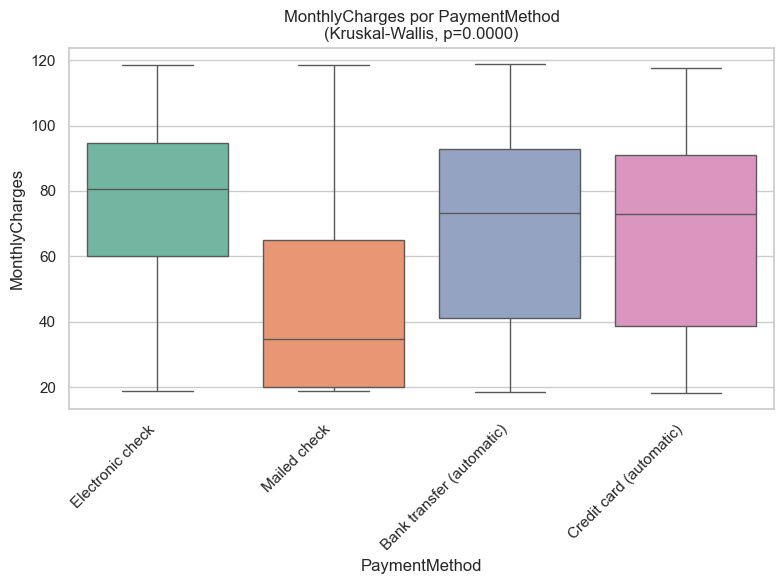

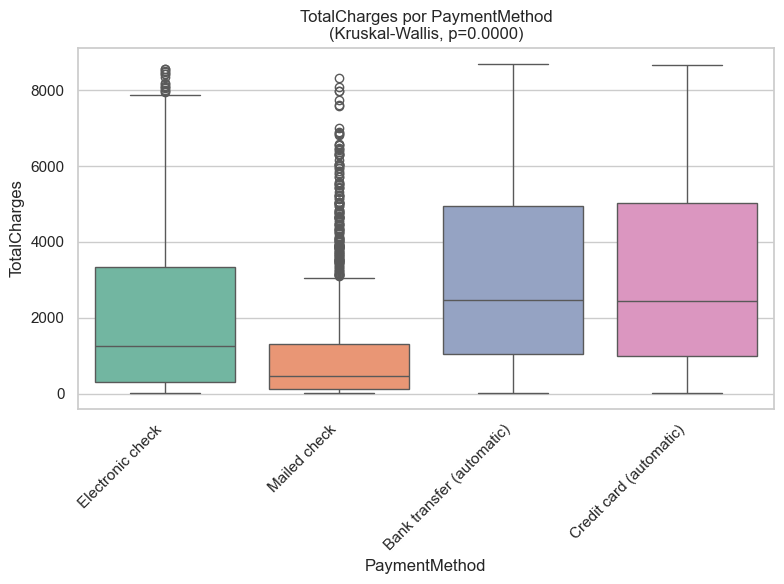

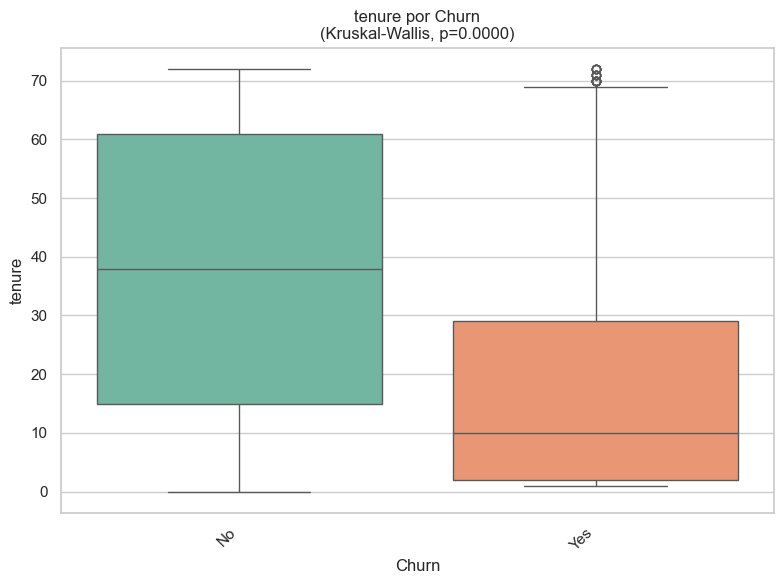

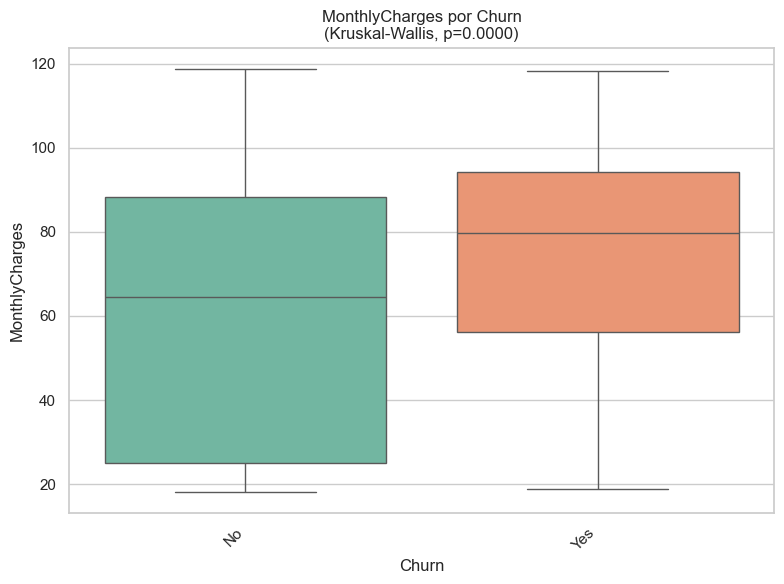

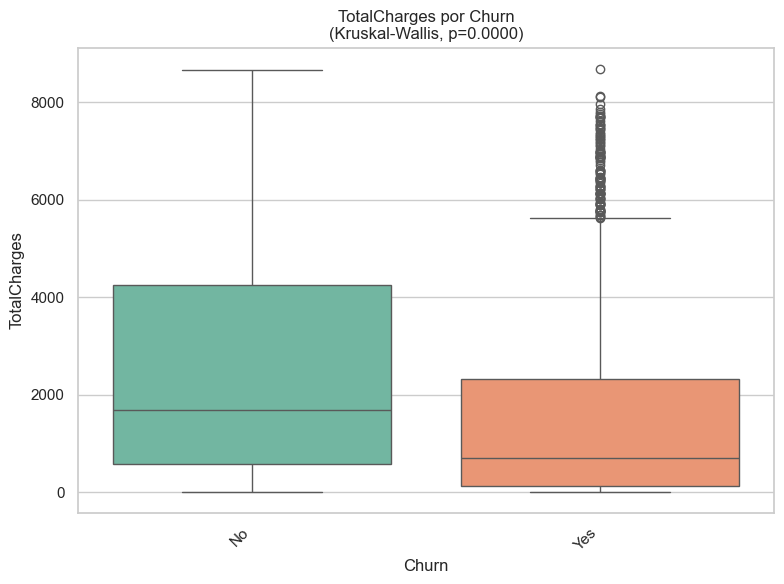

,Categórica,Numérica,Prueba,Normalidad_OK,Homocedasticidad_OK,p-Levene,Estadístico,p-valor
0,gender,tenure,Kruskal-Wallis,False,True,6.580347e-01,0.085589,7.698616e-01
1,gender,MonthlyCharges,Kruskal-Wallis,False,True,4.688119e-01,1.328765,2.490250e-01
2,gender,TotalCharges,Kruskal-Wallis,False,True,8.985335e-01,0.009748,9.213524e-01
3,SeniorCitizen,tenure,Kruskal-Wallis,False,True,1.737419e-01,2.424636,1.194410e-01
4,SeniorCitizen,MonthlyCharges,Kruskal-Wallis,False,False,2.968938e-59,344.145851,7.979832e-77
5,SeniorCitizen,TotalCharges,Kruskal-Wallis,False,False,3.726601e-07,80.871806,2.408455e-19
6,Partner,tenure,Kruskal-Wallis,False,False,7.152704e-21,1043.424215,6.540410e-229
7,Partner,MonthlyCharges,Kruskal-Wallis,False,False,8.582990e-03,82.843189,8.882778e-20
8,Partner,TotalCharges,Kruskal-Wallis,False,False,6.312156e-93,828.136615,4.118937e-182
9,Dependents,tenure,Kruskal-Wallis,False,True,2.588654e-01,189.805949,3.505003e-43


In [26]:
analisis_bivariado_cat_num(df,categoricas=categoricas,numericas=numericas)

Podemos observar que la gran mayoria de variables numericas se relacionan con las categoricas, la unica que no se relaciona es gender por lo que no se considerara para la prediccion

## Analisis de correlaciones

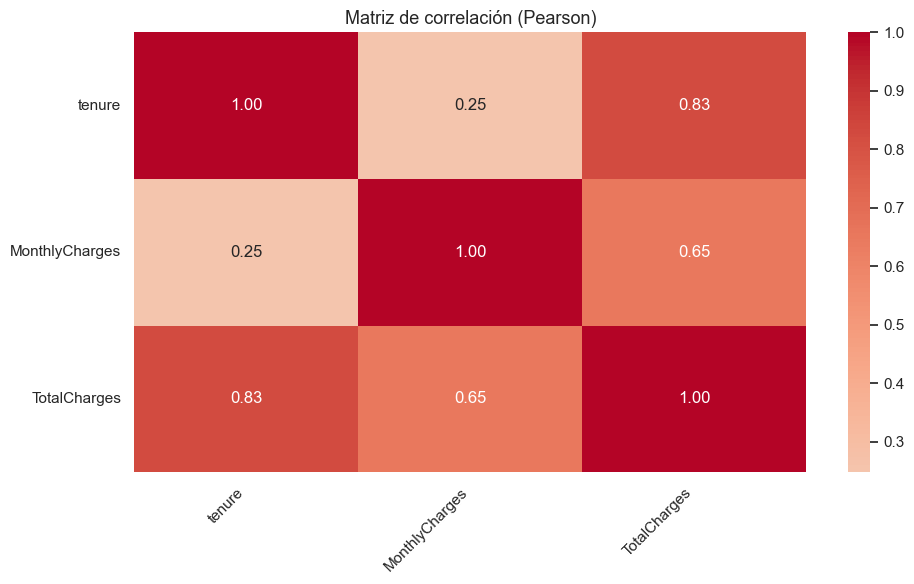

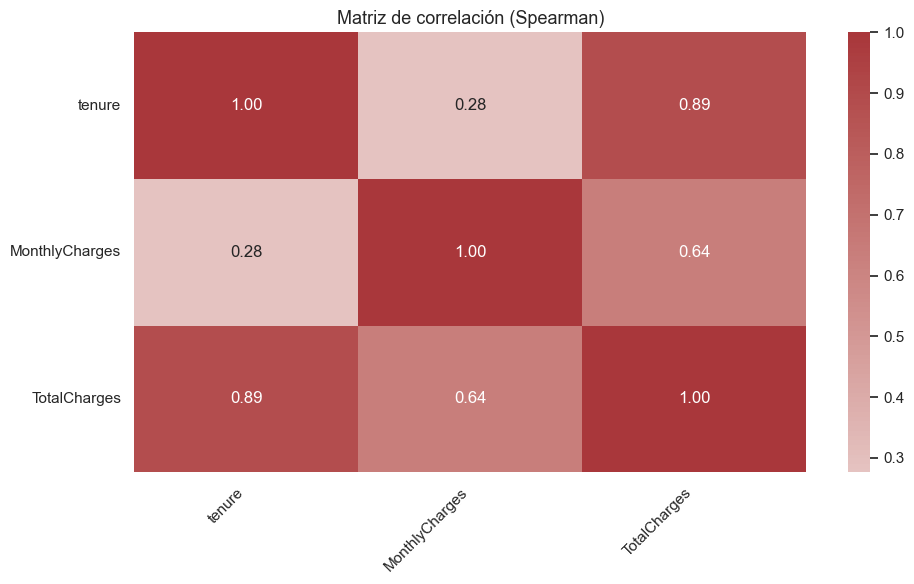

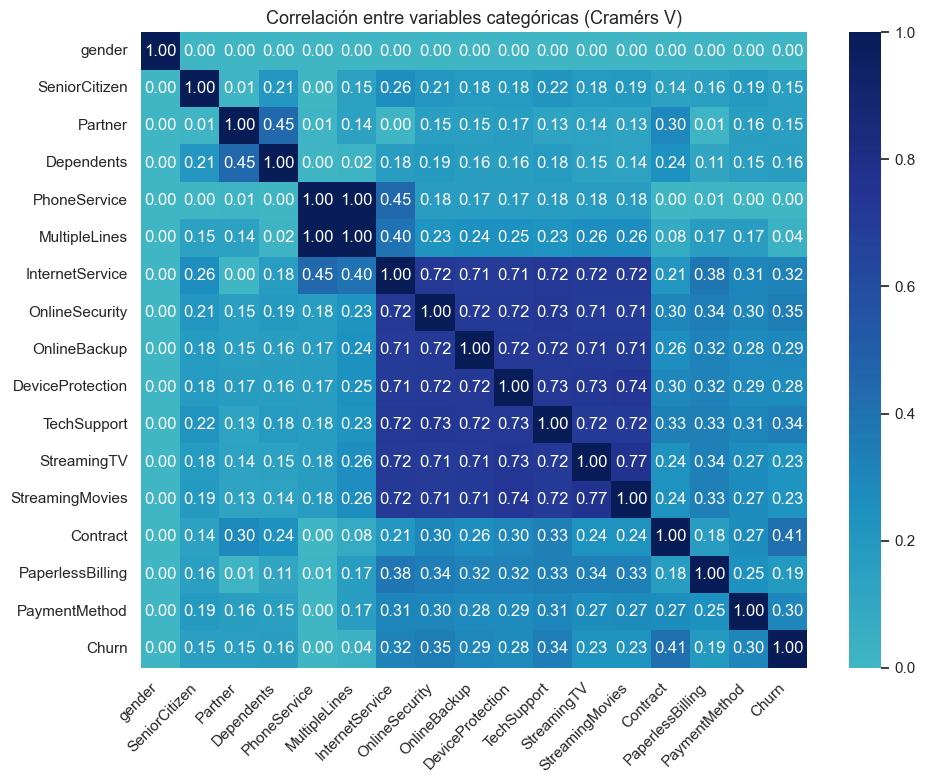

,Variable,VIF,Colinealidad
0,tenure,6.332432,Aceptable
1,MonthlyCharges,3.361075,Aceptable
2,TotalCharges,8.079181,Aceptable


In [27]:
analizar_colinealidad_y_correlaciones(df,mostrar_graficos=True)

Podemos observar que en cuanto a las correlaciones existen varias variables con correlaciones demasiado grandes entre si, al realizar modelos de arboles no se afectan demasiado por alta colinealidad por lo que se mantendran en el dataset 